In [1]:
!pip install torch
!pip install pyldpc

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import torch

import data
import metrics
import plots
import pytorch_spa_nn

np.set_printoptions(precision=3)

## Generate test dataset 

To compare the performance of the trained neural network between different experiment setups. Evaluate how the sum-product-algorithm (SPA) performs on the generated test dataset by calculating the achieved bit-error-rate (BER) for every used signal-to-noise ratio (SNR). 

In [4]:
# generate test dataset
snr_range_test = np.arange(-5, 8.5, 0.5)
codewords_per_snr_test = 2000
codewords_in_dataset_test = snr_range_test.size * codewords_per_snr_test

dataset_test = data.DataSet(
    number_of_codewords=codewords_in_dataset_test,
    batch_size=codewords_in_dataset_test,
    use_all_zero_codeword_only=False,
    snr=snr_range_test,
    codeword_seed=5,
    noise_seed=5,
)

input_llr_test, target_test = dataset_test.generate_data_set(
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch)

x_test = torch.from_numpy(input_llr_test)
y_test = torch.from_numpy(target_test).type(torch.int64)

# executing this part of the cell will take about 2 minutes
spa_BER_per_snr_test = metrics.bers_per_snr_classic_spa(
    input_llr=np.transpose(input_llr_test),
    target=np.transpose(target_test),
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

# Experiment Training Dataset Size
*Hypothesis: "The bigger the fixed training dataset size the better the performance of the trained neural network."*   

Why is this a reasonable hypothesis? Because a bigger training dataset size wil expose the network to more different noise patterns during training, making it easier to generalize noise patterns from a signal-to-noise ratio (SNR) different to the training SNR. The smaller the training data set, the faster the training, therefore the goal is to find the smallest training dataset that performs well.   

For plotting the training loss is normalized with the number of codewords in the training dataset, the validation loss is normalized with the number of codewords in the validation dataset.

**Fixed training parameters:**
- a fixed set of random codewords, not the all-zero-codeword only
- SNR 2
- batch size 26
- fnn structure

**Fixed validation set parameters:**
- 500 random codewords
- SNR 2
- Validation on the validation dataset is done every epoch. 


## Training Dataset Size of 260 Codewords
### Behaviour during training

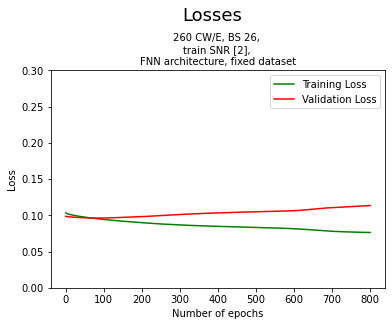

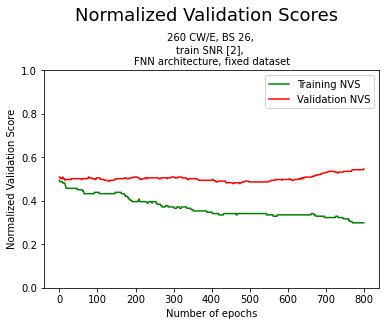

Last epoch loss train = 0.074
Last epoch loss validation = 0.121
NVS train last epoch = 0.299
NVS validation last epoch = 0.573


In [5]:
path_to_checkpoint = os.path.join(
    "checkpoints", 
    "01_ex_1_260cw_bs26_non_all_zero_codewords_in_training-same-train-and-val-snr-500valwords")
checkpoint = torch.load(path_to_checkpoint, map_location=torch.device('cpu'))

plots.plot_from_checkpoint_losses(checkpoint, last_plotted_epoch=800)
plots.plot_from_checkpoint_nvs(checkpoint, last_plotted_epoch=800)
metrics.evaluate_values_for_last_epoch(checkpoint)

The plots show that the training dataset has not enough codewords to generalize well to another dataset from the same SNR distribution. Loss indicates overfitting already before epoch 250, where the normalized validation score (NVS) shows that the neural network is performing better than the sum-product algorithm on both datasets up to epoch 500. A bigger training dataset should help here.

### Trained network evaluation

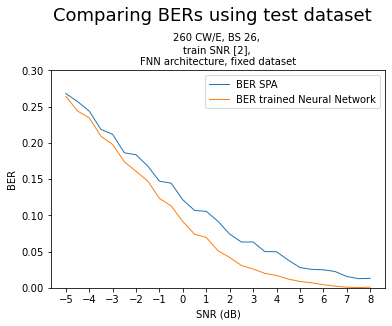

The trained network achieves a normalized validation score (NVS) of 0.566


In [6]:
# load trained neural network
spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

# calculate BER of trained neural network on test dataset 
nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

nvs_test = metrics.calculate_normalized_validation_score(
    bit_error_rate_nn=nn_BER_per_snr_test, 
    bit_error_rate_spa=spa_BER_per_snr_test)

plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

With a NVS of round 0.6 the trained network decodes round 40% better than SPA. When one takes a look at the BER for the different SNRs, one can see that the trained network performs especially well around the SNR used during training. 

## Training Dataset Size of 520 Codewords
### Behaviour during training

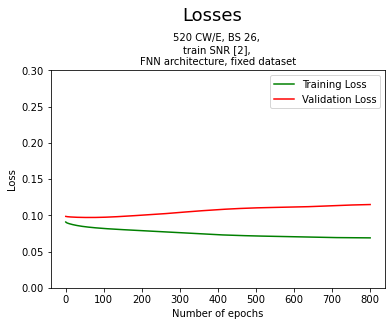

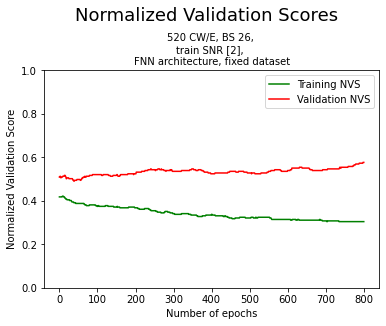

Last epoch loss train = 0.066
Last epoch loss validation = 0.126
NVS train last epoch = 0.314
NVS validation last epoch = 0.603


In [7]:
path_to_checkpoint = os.path.join(
    "checkpoints", 
    "01_ex_2_520cw_bs26_non_all_zero_codewords_in_training-same-train-and-val-snr-500valwords")
checkpoint = torch.load(path_to_checkpoint, map_location=torch.device('cpu'))

plots.plot_from_checkpoint_losses(checkpoint, last_plotted_epoch=800)
plots.plot_from_checkpoint_nvs(checkpoint, last_plotted_epoch=800)
metrics.evaluate_values_for_last_epoch(checkpoint)

With a training dataset of 520 codewords, double the size as the first example, the trained network is not able yet to generalize well on the SNR used for training. 
### Trained network evaluation

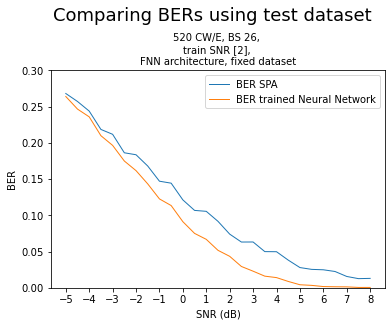

The trained network achieves a normalized validation score (NVS) of 0.54


In [8]:
# load trained neural network
spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

# calculate BER of trained neural network on test dataset 
nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

nvs_test = metrics.calculate_normalized_validation_score(
    bit_error_rate_nn=nn_BER_per_snr_test, 
    bit_error_rate_spa=spa_BER_per_snr_test)

plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

With a NVS of round 0.54 doubling the training dataset lead to a slight improvement in BER when the performance of the network is compared to the performance of SPA. 

## Training Dataset Size of 1040 Codewords
### Behaviour during training

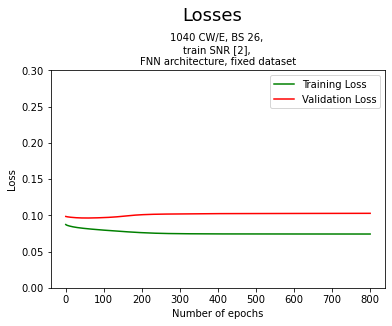

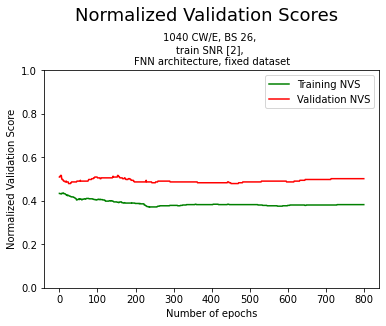

Last epoch loss train = 0.074
Last epoch loss validation = 0.102
NVS train last epoch = 0.384
NVS validation last epoch = 0.506


In [9]:
path_to_checkpoint = os.path.join(
    "checkpoints", 
    "01_ex_3_1040cw_bs26_non_all_zero_codewords_in_training-same-train-and-val-snr-500valwords")
checkpoint = torch.load(path_to_checkpoint, map_location=torch.device('cpu'))

plots.plot_from_checkpoint_losses(checkpoint, last_plotted_epoch=800)
plots.plot_from_checkpoint_nvs(checkpoint, last_plotted_epoch=800)
metrics.evaluate_values_for_last_epoch(checkpoint)

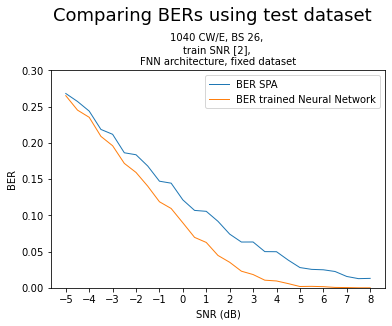

The trained network achieves a normalized validation score (NVS) of 0.495


In [10]:
# load trained neural network
spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

# calculate BER of trained neural network on test dataset 
nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

nvs_test = metrics.calculate_normalized_validation_score(
    bit_error_rate_nn=nn_BER_per_snr_test, 
    bit_error_rate_spa=spa_BER_per_snr_test)

plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

## Training Dataset Size of 2080 Codewords
### Behaviour during training

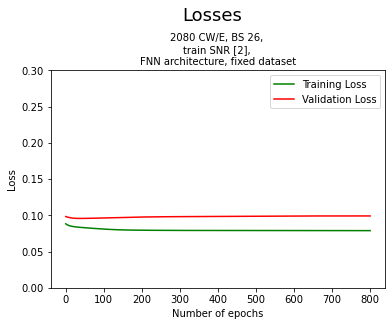

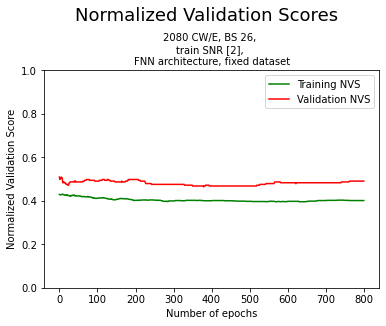

Last epoch loss train = 0.079
Last epoch loss validation = 0.099
NVS train last epoch = 0.399
NVS validation last epoch = 0.487


In [11]:
path_to_checkpoint = os.path.join(
    "checkpoints", 
    "01_ex_4_2080cw_bs26_non_all_zero_codewords_in_training-same-train-and-val-snr-500valwords")

checkpoint = torch.load(path_to_checkpoint, map_location=torch.device('cpu'))

plots.plot_from_checkpoint_losses(checkpoint, last_plotted_epoch=800)
plots.plot_from_checkpoint_nvs(checkpoint, last_plotted_epoch=800)
metrics.evaluate_values_for_last_epoch(checkpoint)

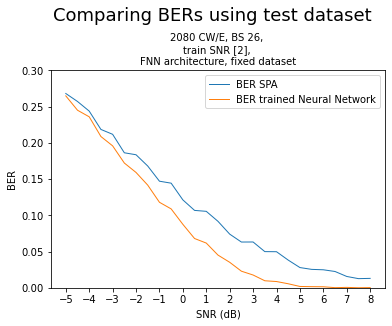

The trained network achieves a normalized validation score (NVS) of 0.493


In [12]:
# load trained neural network
spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

# calculate BER of trained neural network on test dataset 
nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

nvs_test = metrics.calculate_normalized_validation_score(
    bit_error_rate_nn=nn_BER_per_snr_test, 
    bit_error_rate_spa=spa_BER_per_snr_test)

plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

## Training Dataset Size of 5200 Codewords
### Behaviour during training

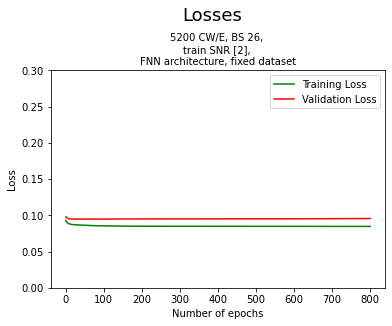

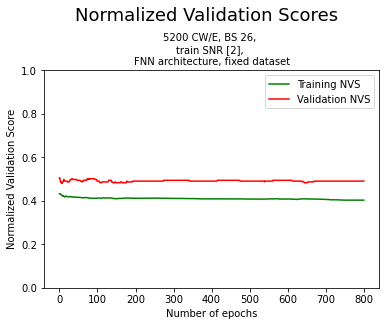

Last epoch loss train = 0.084
Last epoch loss validation = 0.094
NVS train last epoch = 0.405
NVS validation last epoch = 0.487


In [13]:
path_to_checkpoint = os.path.join(
    "checkpoints", 
    "01_ex_5_5200cw_bs26_non_all_zero_codewords_in_training-same-train-and-val-snr-500valwords")

checkpoint = torch.load(path_to_checkpoint, map_location=torch.device('cpu'))

plots.plot_from_checkpoint_losses(checkpoint, last_plotted_epoch=800)
plots.plot_from_checkpoint_nvs(checkpoint, last_plotted_epoch=800)
metrics.evaluate_values_for_last_epoch(checkpoint)

Using 20 times more codewords than in the initial experiment it seems that the drawback of overfitting to the training SNR has been overcome. 
### Trained network evaluation

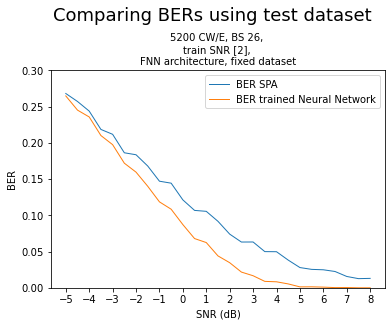

The trained network achieves a normalized validation score (NVS) of 0.487


In [14]:
# load trained neural network
spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

# calculate BER of trained neural network on test dataset 
nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

nvs_test = metrics.calculate_normalized_validation_score(
    bit_error_rate_nn=nn_BER_per_snr_test, 
    bit_error_rate_spa=spa_BER_per_snr_test)

plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

With a NVS of round 0.5 using a 20 times bigger training dataset lead to a round 12% improvement in BER when the performance of the network is compared to the performance of SPA.

# Compare BERs on test dataset for experiment parameters

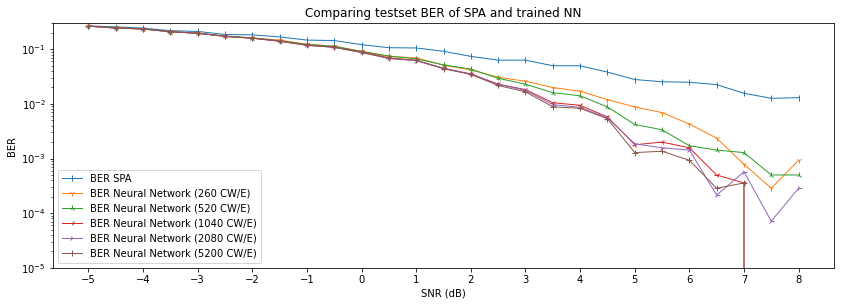

Wall time: 2min 18s


In [15]:
%%time
# executing this cell will take ~ 2.5 minutes
paths_to_experiment_checkpoints = glob.glob(os.path.join(
    "checkpoints", 
    "*non_all_zero_codewords*"))

results_to_plot = {}

for path in paths_to_experiment_checkpoints:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    label = f'{checkpoint["codewords_in_dataset_train"]} CW/E'
    
    # load trained neural network
    spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
    spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

    # calculate BER of trained neural network on test dataset 
    nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

    nvs_test = metrics.calculate_normalized_validation_score(
        bit_error_rate_nn=nn_BER_per_snr_test, 
        bit_error_rate_spa=spa_BER_per_snr_test)
    
    results_to_plot[label] = [nn_BER_per_snr_test, nvs_test]

plots.plot_multiple_bers_per_snr(results_to_plot, snr_range_test, spa_BER_per_snr_test=spa_BER_per_snr_test)

# Experiment Train on All-Zero Codeword
*Hypothesis: "It does not matter if the all-zero codeword only or randomly picked codewords are used in the training data set."*   

As the performance of SPA is independent of the transmitted codeword and the transformation of SPA to the NND via unfolding the Tanner graph does not change the flow of information the NND should also be independent of the codewords it is trained on. The decoding performance should not depend on the values of the transmitted bits but on the error patterns induced by the channel. This is because output produced by variable nodes and check nodes is a function of the error-patterns in the channel input represented by the LLR.

For plotting the training loss is normalized with the number of codewords in the training dataset, the validation loss is normalized with the number of codewords in the validation dataset.

**Fixed training parameters:**
- 5200 CW/E
- SNR 2
- batch size 26
- fnn structure

**Fixed validation set parameters:**
- 500 codewords (once random, once the all zero codeword) 
- SNR 2
- Validation on the validation dataset is done every epoch.

## Training on random codeword, validate with random
### Behaviour during training

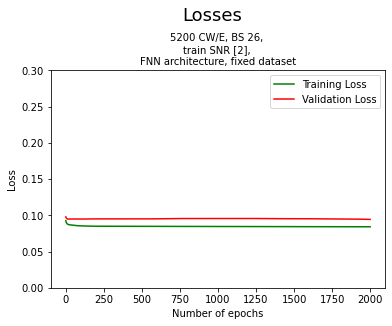

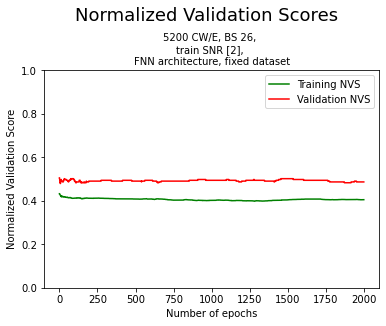

Last epoch loss train = 0.084
Last epoch loss validation = 0.094
NVS train last epoch = 0.405
NVS validation last epoch = 0.487


In [16]:
# reuse example we already calculated with random codewords in training and validation set
path_to_checkpoint = os.path.join(
    "checkpoints", 
    "01_ex_5_5200cw_bs26_non_all_zero_codewords_in_training-same-train-and-val-snr-500valwords")
checkpoint = torch.load(path_to_checkpoint, map_location=torch.device('cpu'))

plots.plot_from_checkpoint_losses(checkpoint)
plots.plot_from_checkpoint_nvs(checkpoint)
metrics.evaluate_values_for_last_epoch(checkpoint)

### Trained network evaluation

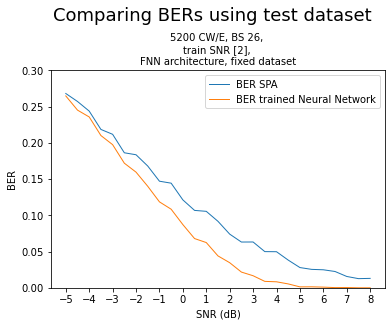

The trained network achieves a normalized validation score (NVS) of 0.487


In [17]:
# load trained neural network
spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

# calculate BER of trained neural network on test dataset 
nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

nvs_test = metrics.calculate_normalized_validation_score(
    bit_error_rate_nn=nn_BER_per_snr_test, 
    bit_error_rate_spa=spa_BER_per_snr_test)

plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

## Training on the all-zero codeword, validate with all-zero codeword
### Behaviour during training

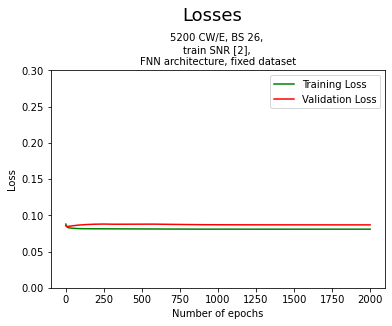

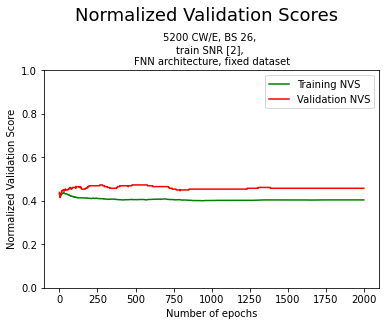

Last epoch loss train = 0.081
Last epoch loss validation = 0.087
NVS train last epoch = 0.404
NVS validation last epoch = 0.458


In [18]:
path_to_checkpoint = os.path.join(
    "checkpoints", 
    "2021-06-22_10-08-07_ex_all_zero_5200cw_bs26_0_0")

checkpoint = torch.load(path_to_checkpoint, map_location=torch.device('cpu'))

plots.plot_from_checkpoint_losses(checkpoint)
plots.plot_from_checkpoint_nvs(checkpoint)
metrics.evaluate_values_for_last_epoch(checkpoint)

### Trained network evaluation

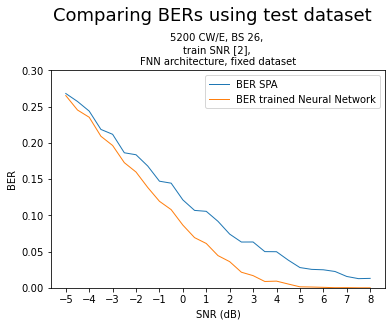

The trained network achieves a normalized validation score (NVS) of 0.486


In [19]:
# load trained neural network
spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

# calculate BER of trained neural network on test dataset 
nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

nvs_test = metrics.calculate_normalized_validation_score(
    bit_error_rate_nn=nn_BER_per_snr_test, 
    bit_error_rate_spa=spa_BER_per_snr_test)

plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

## Training on random codewords, validate with all-zero codeword
### Behaviour during training

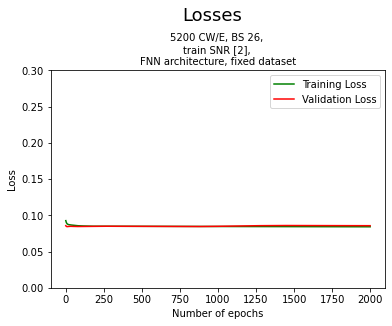

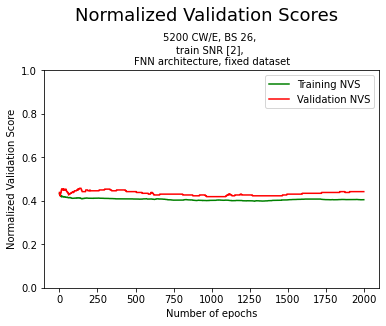

Last epoch loss train = 0.084
Last epoch loss validation = 0.086
NVS train last epoch = 0.405
NVS validation last epoch = 0.442


In [20]:
path_to_checkpoint = os.path.join(
    "checkpoints", 
    "2021-06-22_10-09-26_ex_all_zero_5200cw_bs26_rnd_0")

checkpoint = torch.load(path_to_checkpoint, map_location=torch.device('cpu'))

plots.plot_from_checkpoint_losses(checkpoint)
plots.plot_from_checkpoint_nvs(checkpoint)
metrics.evaluate_values_for_last_epoch(checkpoint)

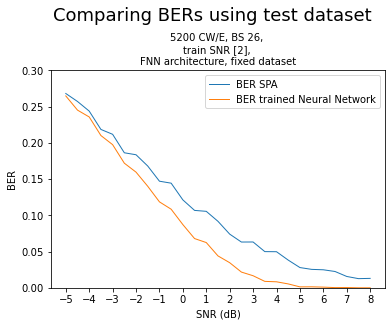

The trained network achieves a normalized validation score (NVS) of 0.487


In [21]:
# load trained neural network
spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

# calculate BER of trained neural network on test dataset 
nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

nvs_test = metrics.calculate_normalized_validation_score(
    bit_error_rate_nn=nn_BER_per_snr_test, 
    bit_error_rate_spa=spa_BER_per_snr_test)

plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

## Training on all-zero codeword, validate with random codeword
### Behaviour during training

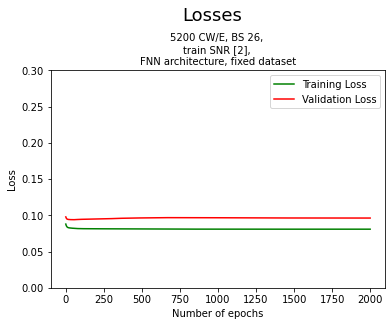

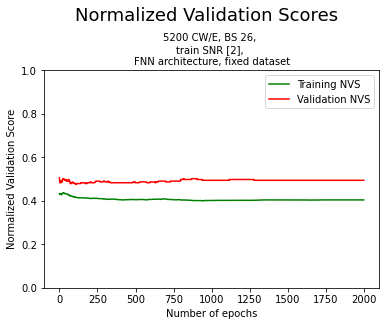

Last epoch loss train = 0.081
Last epoch loss validation = 0.096
NVS train last epoch = 0.404
NVS validation last epoch = 0.494


In [22]:
path_to_checkpoint = os.path.join(
    "checkpoints", 
    "2021-06-22_11-01-02_ex_all_zero_5200cw_bs26_0_rnd")

checkpoint = torch.load(path_to_checkpoint, map_location=torch.device('cpu'))

plots.plot_from_checkpoint_losses(checkpoint)
plots.plot_from_checkpoint_nvs(checkpoint)

# load trained neural network
spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])
metrics.evaluate_values_for_last_epoch(checkpoint)

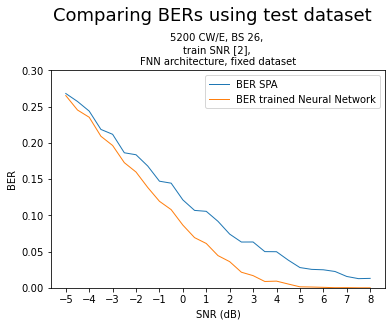

The trained network achieves a normalized validation score (NVS) of 0.486


In [23]:
# load trained neural network
spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

# calculate BER of trained neural network on test dataset 
nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

nvs_test = metrics.calculate_normalized_validation_score(
    bit_error_rate_nn=nn_BER_per_snr_test, 
    bit_error_rate_spa=spa_BER_per_snr_test)

plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

## Compare train loss of random codewords with all-zero codewords

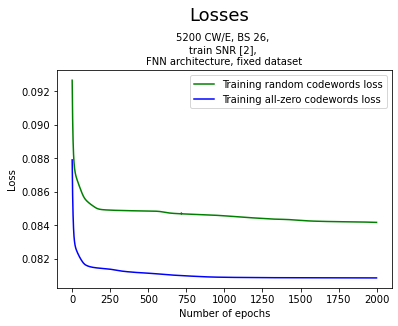

In [24]:
path_to_training_with_random = os.path.join(
    "checkpoints", 
    "01_ex_5_5200cw_bs26_non_all_zero_codewords_in_training-same-train-and-val-snr-500valwords")
checkpoint_random = torch.load(path_to_training_with_random, map_location=torch.device('cpu'))
losses_random = checkpoint_random["losses_train"]
losses_random_normalized = [loss / checkpoint_random["codewords_in_dataset_train"] for loss in losses_random]

path_to_training_with_random1 = os.path.join(
    "checkpoints", 
    "2021-06-22_10-09-26_ex_all_zero_5200cw_bs26_rnd_0")
checkpoint_random1 = torch.load(path_to_training_with_random1, map_location=torch.device('cpu'))
losses_random1 = checkpoint_random1["losses_train"]
losses_random1_normalized = [loss / checkpoint_random1["codewords_in_dataset_train"] for loss in losses_random1]


path_to_training_with_all_zero = os.path.join(
    "checkpoints", 
    "2021-06-22_10-08-07_ex_all_zero_5200cw_bs26_0_0")
checkpoint_all_zero = torch.load(path_to_training_with_all_zero, map_location=torch.device('cpu'))
losses_all_zero = checkpoint_all_zero["losses_train"] 
losses_all_zero_normalized = [loss / checkpoint_all_zero["codewords_in_dataset_train"] for loss in losses_all_zero]

path_to_training_with_all_zero1 = os.path.join(
    "checkpoints", 
    "2021-06-22_11-01-02_ex_all_zero_5200cw_bs26_0_rnd")
checkpoint_all_zero1 = torch.load(path_to_training_with_all_zero1, map_location=torch.device('cpu'))
losses_all_zero1 = checkpoint_all_zero1["losses_train"] 
losses_all_zero1_normalized = [loss / checkpoint_all_zero1["codewords_in_dataset_train"] for loss in losses_all_zero1]

x_axis = [i for i in range(checkpoint_random["epoch"] + 1)]
plt.plot(x_axis, losses_random_normalized, label="Training random codewords loss", color="green")
#plt.plot(x_axis, losses_random1_normalized, label="Training random codewords loss", color="lightgreen")
plt.plot(x_axis, losses_all_zero_normalized, label="Training all-zero codewords loss", color="blue")
#plt.plot(x_axis, losses_all_zero1_normalized, label="Training all-zero codewords loss", color="purple")
#plt.ylim((0, 0.3))
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
codewords_in_dataset_train = checkpoint_random["codewords_in_dataset_train"]
batchsize = checkpoint_random["batch_size_train"]
snr_range_train = checkpoint_random["snr_range_train"]
architecture = checkpoint_random["network_architecture"]
dataset_state_train = checkpoint_random["dataset_state_train"]
plt.suptitle("Losses", fontsize=18, y=1.1)
plt.title(f"{codewords_in_dataset_train} CW/E, BS {batchsize}, \ntrain SNR {snr_range_train}, \n{architecture.upper()} architecture, {dataset_state_train} dataset", fontsize=10)
#plt.savefig(os.path.join("../", "bachelor_thesis", "plots", "experiments-all-zero-codeword", f"compare_losses_{codewords_in_dataset_train}cw_{batchsize}bs_snr{snr_range_train}_{architecture}_{dataset_state_train}.pdf"), bbox_inches='tight')
plt.show()

# Experiment Batchsize
*Hypothesis: "Code size and batch size share a linear dependency."*   

The expectation is a sweet spot around batch size 64 because the code based on the parity check matrix in this example is a fourth of the size of the code described in the subsection were a batch size of 256 was recommended. If code and batch size share a linear dependency it would make sense to reduce also the batch size to a fourth.
To compare different batch sizes the number of codewords per epoch is set to a fixed value because the loss and NVS is calculated for a whole epoch. For easier calculation multiples of two are taken into account for possible batch sizes, starting with 16 going up to 256.

For plotting the training loss is normalized with the number of codewords in the training dataset, the validation loss is normalized with the number of codewords in the validation dataset.

**Fixed training parameters:**
- all-zero codeword 
- 4096 CW/E
- BS 32
- SNR 2
- fnn structure

**Fixed validation set parameters:**
- 500 all-zero codewords
- SNR 2
- Validation on the validation dataset is done every epoch.

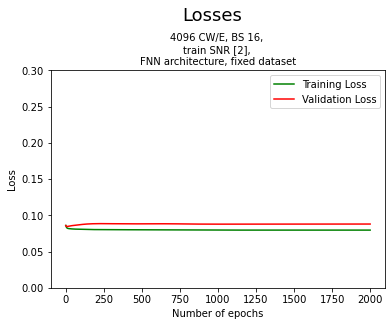

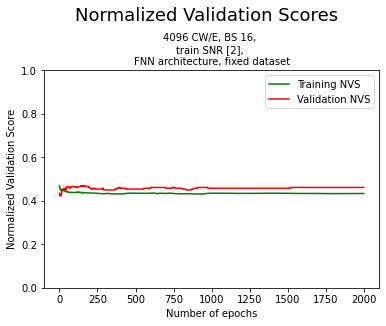

Last epoch loss train = 0.08
Last epoch loss validation = 0.088
NVS train last epoch = 0.434
NVS validation last epoch = 0.462


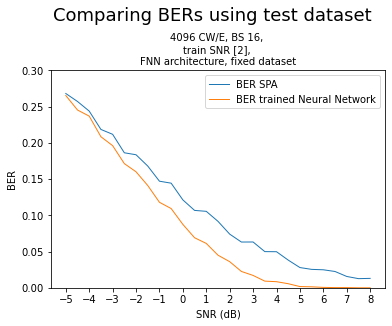

The trained network achieves a normalized validation score (NVS) of 0.489


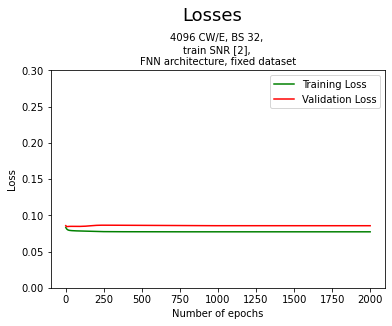

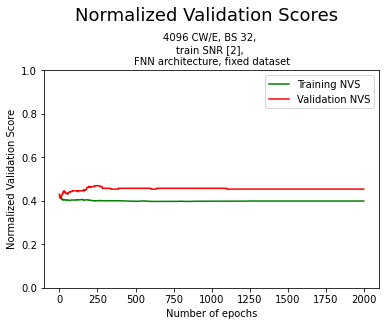

Last epoch loss train = 0.077
Last epoch loss validation = 0.086
NVS train last epoch = 0.399
NVS validation last epoch = 0.454


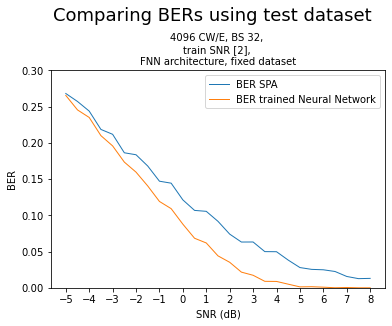

The trained network achieves a normalized validation score (NVS) of 0.488


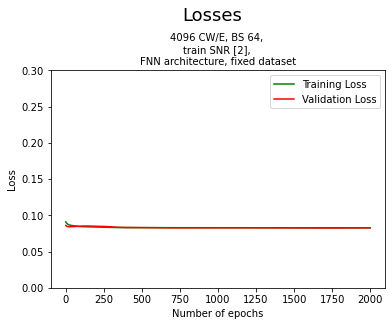

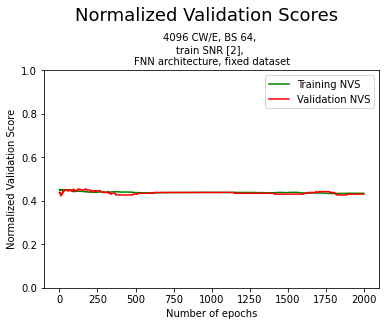

Last epoch loss train = 0.083
Last epoch loss validation = 0.083
NVS train last epoch = 0.435
NVS validation last epoch = 0.431


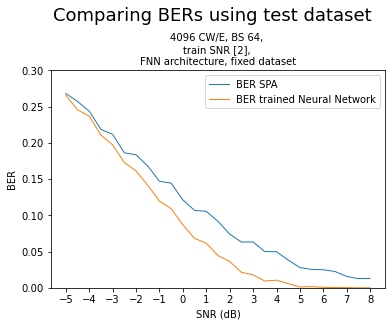

The trained network achieves a normalized validation score (NVS) of 0.492


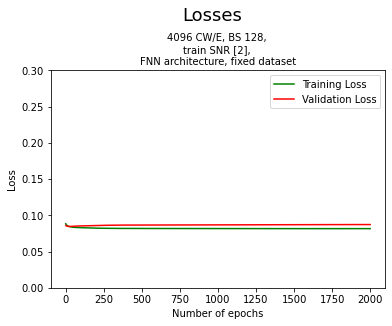

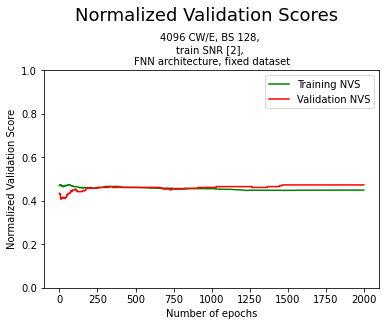

Last epoch loss train = 0.082
Last epoch loss validation = 0.087
NVS train last epoch = 0.449
NVS validation last epoch = 0.473


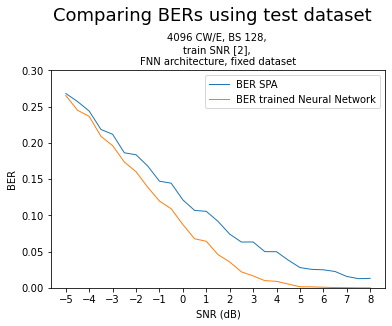

The trained network achieves a normalized validation score (NVS) of 0.49


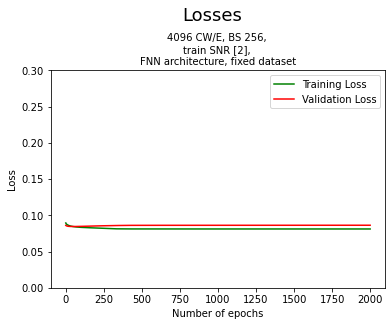

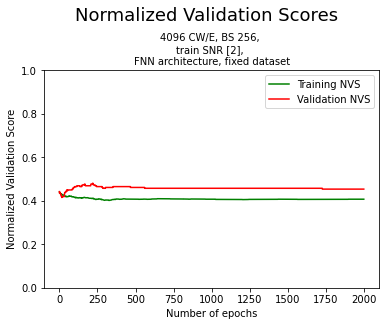

Last epoch loss train = 0.081
Last epoch loss validation = 0.086
NVS train last epoch = 0.407
NVS validation last epoch = 0.454


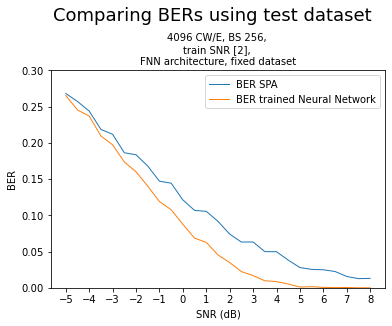

The trained network achieves a normalized validation score (NVS) of 0.489


In [25]:
paths_to_experiment_checkpoints = glob.glob(os.path.join(
    "checkpoints", 
    "*batchsize*"))

for path in paths_to_experiment_checkpoints:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))

    plots.plot_from_checkpoint_losses(checkpoint)
    plots.plot_from_checkpoint_nvs(checkpoint)
    metrics.evaluate_values_for_last_epoch(checkpoint)

    # load trained neural network
    spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
    spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

    # calculate BER of trained neural network on test dataset 
    nn_BER_per_snr_test = metrics.bers_per_snr_nn(
        spa_nn=spa_nn_to_test,
        input_llr=x_test,
        target=y_test,
        codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
        batch_size=codewords_in_dataset_test)

    nvs_test = metrics.calculate_normalized_validation_score(
        bit_error_rate_nn=nn_BER_per_snr_test, 
        bit_error_rate_spa=spa_BER_per_snr_test)

    plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
    print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

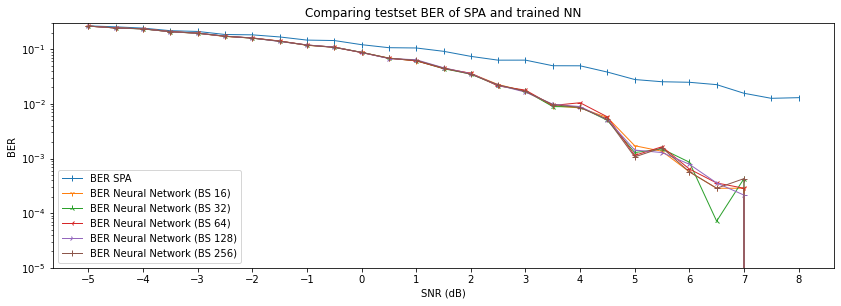

In [26]:
# executing this cell will take ~ 2.5 minutes
paths_to_experiment_checkpoints = glob.glob(os.path.join("checkpoints", "*batchsize*"))
results_to_plot = {}

for path in paths_to_experiment_checkpoints:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    label = f'BS {checkpoint["batch_size_train"]}'
    
    # load trained neural network
    spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
    spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

    # calculate BER of trained neural network on test dataset 
    nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

    nvs_test = metrics.calculate_normalized_validation_score(
        bit_error_rate_nn=nn_BER_per_snr_test, 
        bit_error_rate_spa=spa_BER_per_snr_test)
    
    results_to_plot[label] = [nn_BER_per_snr_test, nvs_test]

plots.plot_multiple_bers_per_snr(results_to_plot, snr_range_test, spa_BER_per_snr_test=spa_BER_per_snr_test)

# Experiment SNR Combinations for Training
*Hypothesis: "Training on only one SNR leads to results equivalent to using a range of SNRs in the training data set."*   

For plotting the training loss is normalized with the number of codewords in the training dataset, the validation loss is normalized with the number of codewords in the validation dataset.

**Fixed training parameters:**
- all-zero codeword 
- 4096 CW/E
- batch size 64
- fnn structure

**Fixed validation set parameters:**
- 500 random codewords 
- use SNR from training dataset
- Validation on the validation dataset is done every epoch.

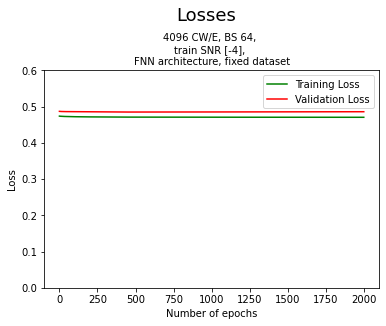

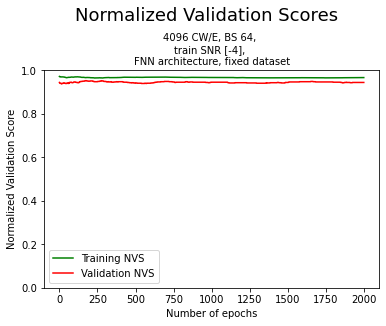

Last epoch loss train = 0.471
Last epoch loss validation = 0.486
NVS train last epoch = 0.967
NVS validation last epoch = 0.944


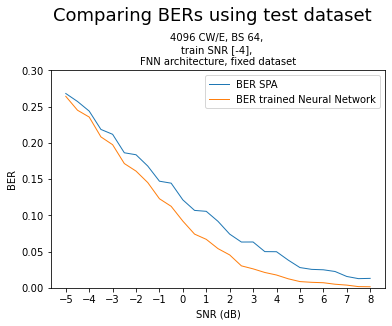

The trained network achieves a normalized validation score (NVS) of 0.59


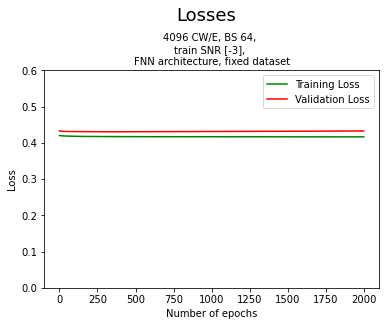

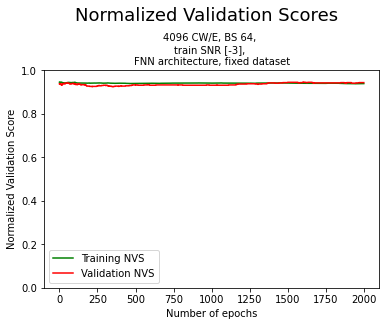

Last epoch loss train = 0.416
Last epoch loss validation = 0.433
NVS train last epoch = 0.939
NVS validation last epoch = 0.944


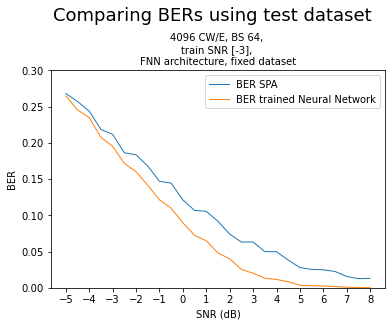

The trained network achieves a normalized validation score (NVS) of 0.52


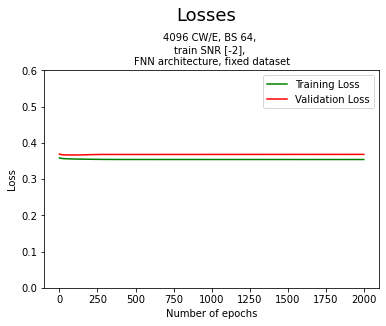

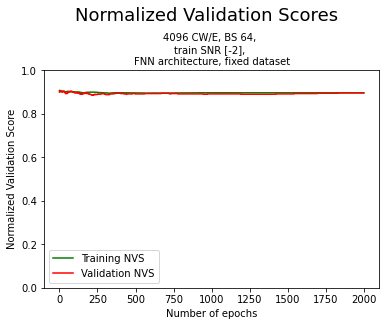

Last epoch loss train = 0.354
Last epoch loss validation = 0.368
NVS train last epoch = 0.896
NVS validation last epoch = 0.896


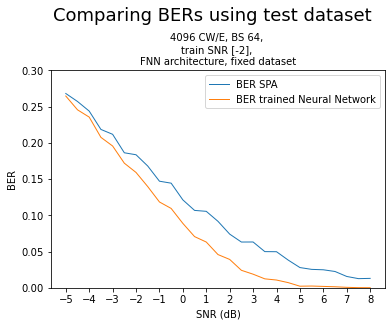

The trained network achieves a normalized validation score (NVS) of 0.507


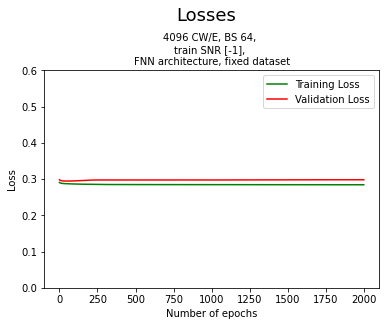

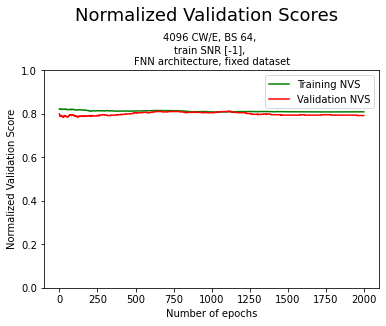

Last epoch loss train = 0.284
Last epoch loss validation = 0.298
NVS train last epoch = 0.809
NVS validation last epoch = 0.792


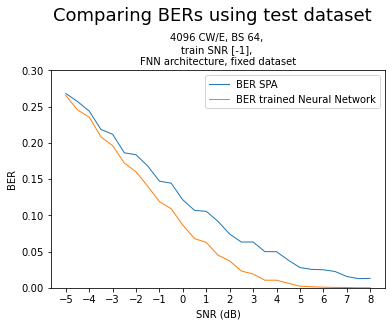

The trained network achieves a normalized validation score (NVS) of 0.496


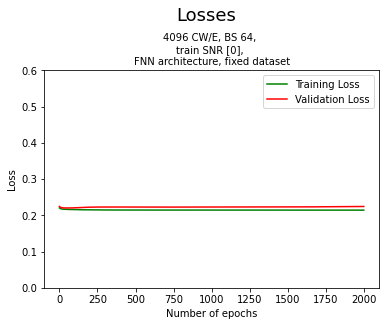

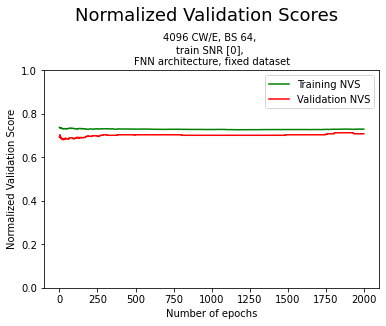

Last epoch loss train = 0.214
Last epoch loss validation = 0.224
NVS train last epoch = 0.73
NVS validation last epoch = 0.708


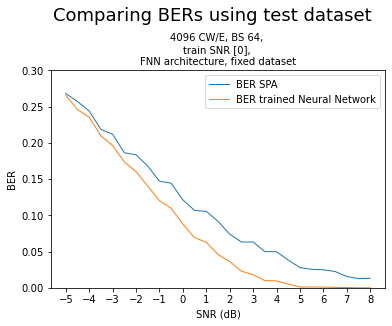

The trained network achieves a normalized validation score (NVS) of 0.494


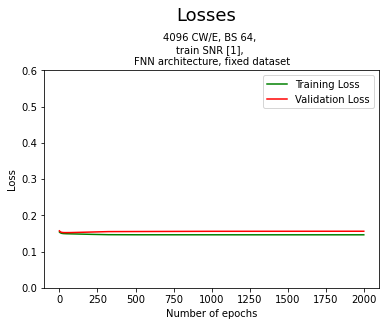

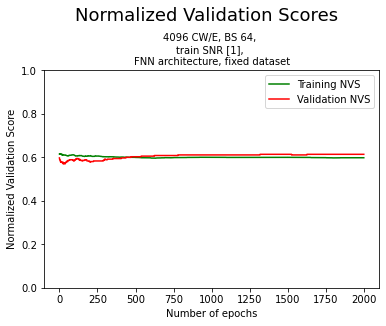

Last epoch loss train = 0.146
Last epoch loss validation = 0.156
NVS train last epoch = 0.598
NVS validation last epoch = 0.614


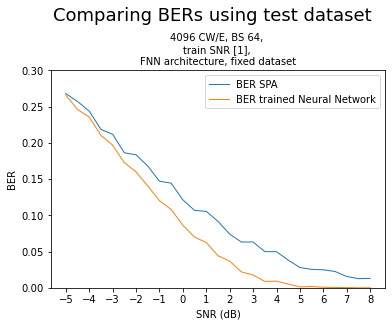

The trained network achieves a normalized validation score (NVS) of 0.491


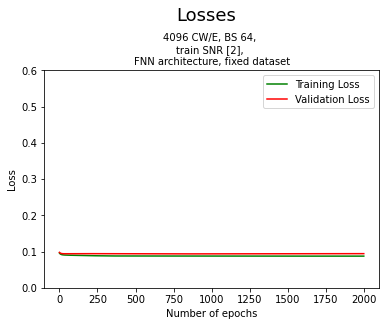

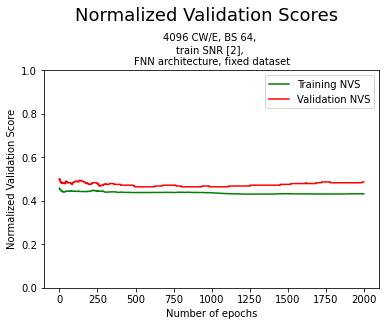

Last epoch loss train = 0.087
Last epoch loss validation = 0.094
NVS train last epoch = 0.433
NVS validation last epoch = 0.487


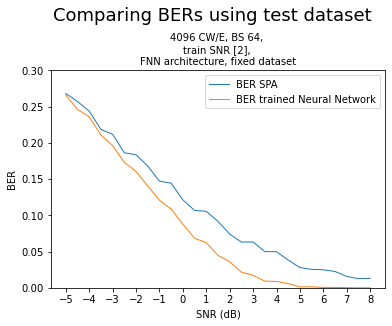

The trained network achieves a normalized validation score (NVS) of 0.49


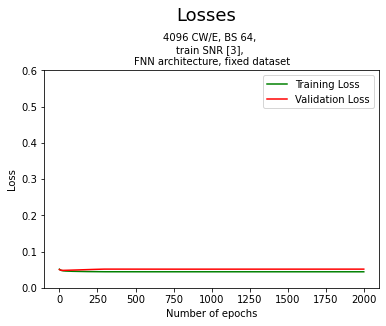

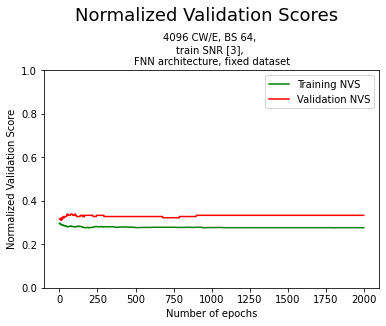

Last epoch loss train = 0.044
Last epoch loss validation = 0.052
NVS train last epoch = 0.276
NVS validation last epoch = 0.333


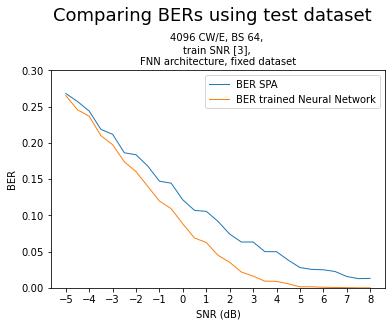

The trained network achieves a normalized validation score (NVS) of 0.49


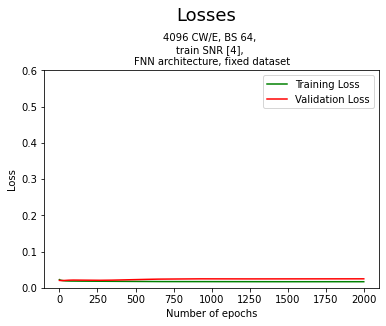

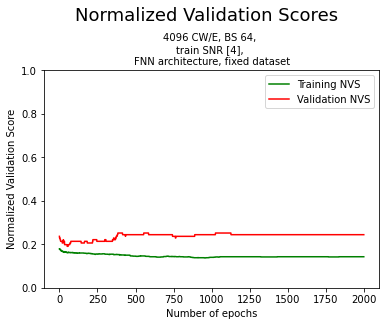

Last epoch loss train = 0.017
Last epoch loss validation = 0.025
NVS train last epoch = 0.143
NVS validation last epoch = 0.244


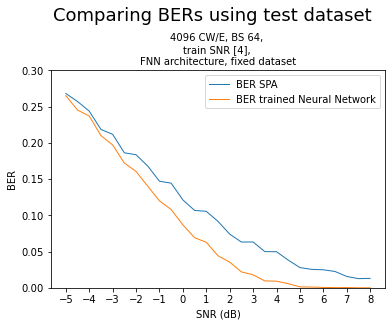

The trained network achieves a normalized validation score (NVS) of 0.49


In [27]:
paths_to_experiment_checkpoints = glob.glob(os.path.join(
    "checkpoints", 
    "*one_snr*"))

for path in paths_to_experiment_checkpoints:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))

    plots.plot_from_checkpoint_losses(checkpoint, ylim=(0, 0.6))
    plots.plot_from_checkpoint_nvs(checkpoint)
    metrics.evaluate_values_for_last_epoch(checkpoint)

    # load trained neural network
    spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
    spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

    # calculate BER of trained neural network on test dataset 
    nn_BER_per_snr_test = metrics.bers_per_snr_nn(
        spa_nn=spa_nn_to_test,
        input_llr=x_test,
        target=y_test,
        codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
        batch_size=codewords_in_dataset_test)

    nvs_test = metrics.calculate_normalized_validation_score(
        bit_error_rate_nn=nn_BER_per_snr_test, 
        bit_error_rate_spa=spa_BER_per_snr_test)

    plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
    print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

## Combining SNRs

**Fixed training parameters:**
- all-zero codeword 
- 4200 CW/E for 5 and 6 SNRs, 4221 CW/E for 7 SNRs, 4224 for 4 SNRs
- batch size 64 for 4 SNRs, batch size 63 for 3 and 7 SNRs, batch size 60 for 5 and 6 SNRs
- fnn structure
- 750 epochs

**Fixed validation set parameters:**
- 420 random codewords 
- use SNR from training dataset
- Validation on the validation dataset is done every epoch.

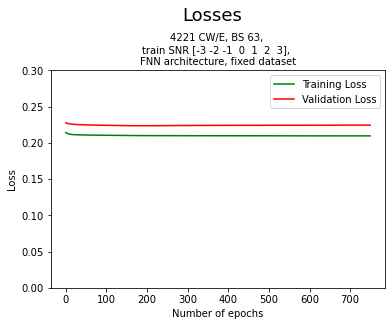

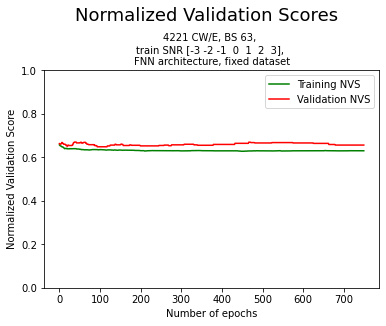

Last epoch loss train = 0.21
Last epoch loss validation = 0.224
NVS train last epoch = 0.63
NVS validation last epoch = 0.656


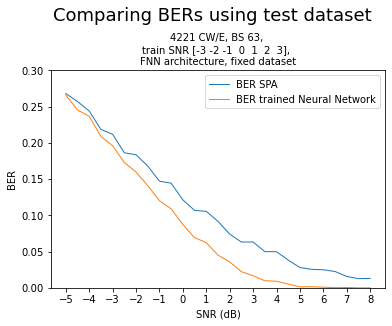

The trained network achieves a normalized validation score (NVS) of 0.49


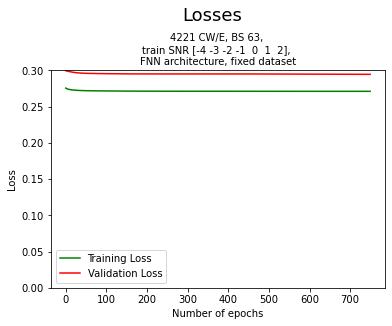

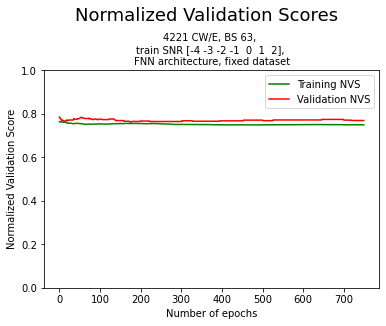

Last epoch loss train = 0.271
Last epoch loss validation = 0.295
NVS train last epoch = 0.75
NVS validation last epoch = 0.769


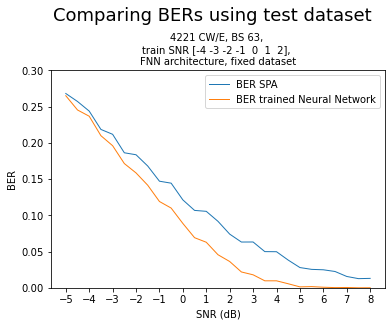

The trained network achieves a normalized validation score (NVS) of 0.493


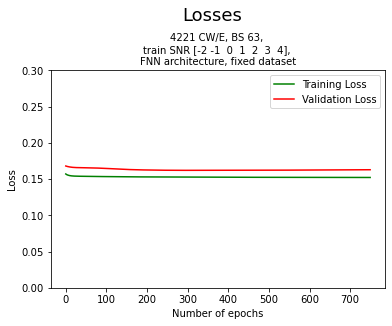

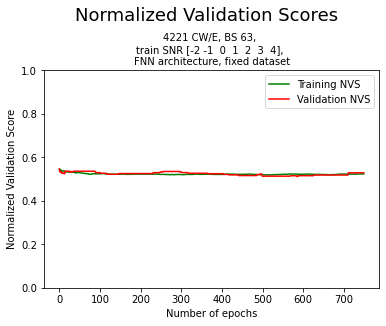

Last epoch loss train = 0.152
Last epoch loss validation = 0.163
NVS train last epoch = 0.523
NVS validation last epoch = 0.529


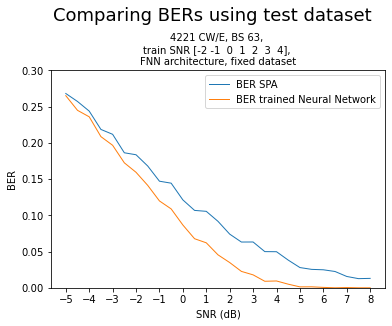

The trained network achieves a normalized validation score (NVS) of 0.488


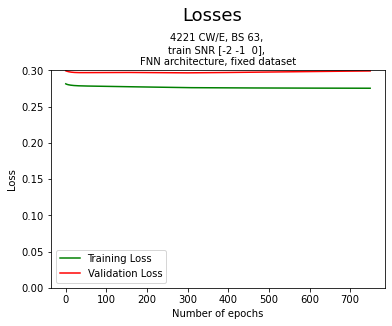

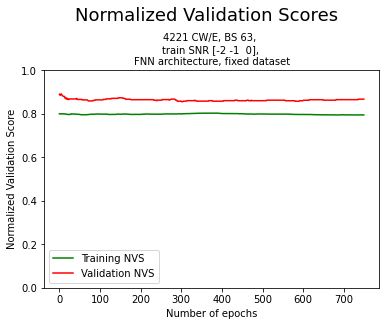

Last epoch loss train = 0.275
Last epoch loss validation = 0.299
NVS train last epoch = 0.795
NVS validation last epoch = 0.868


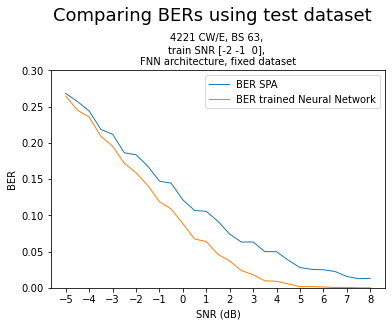

The trained network achieves a normalized validation score (NVS) of 0.494


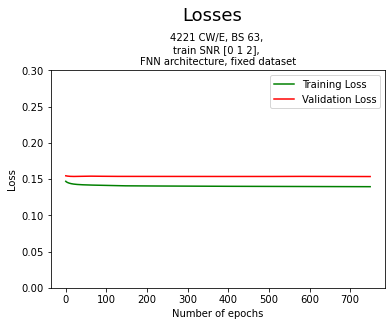

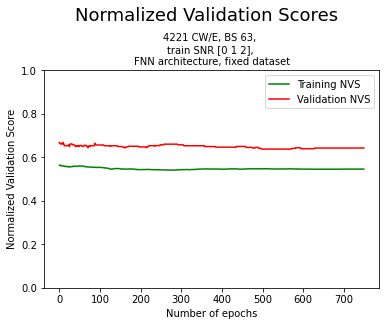

Last epoch loss train = 0.14
Last epoch loss validation = 0.154
NVS train last epoch = 0.546
NVS validation last epoch = 0.643


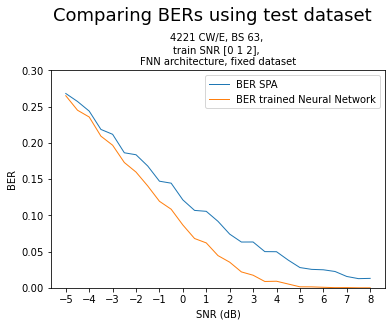

The trained network achieves a normalized validation score (NVS) of 0.487


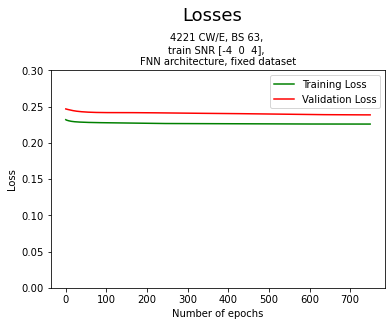

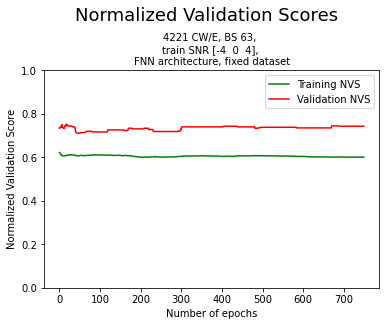

Last epoch loss train = 0.226
Last epoch loss validation = 0.239
NVS train last epoch = 0.601
NVS validation last epoch = 0.743


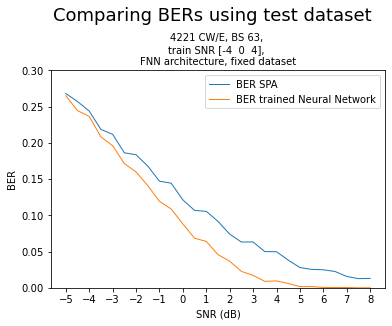

The trained network achieves a normalized validation score (NVS) of 0.492


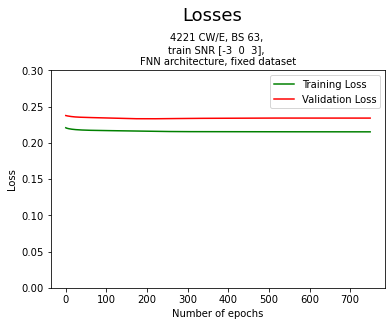

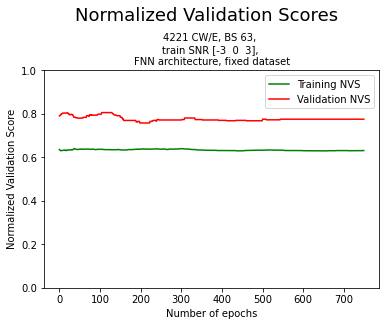

Last epoch loss train = 0.215
Last epoch loss validation = 0.234
NVS train last epoch = 0.631
NVS validation last epoch = 0.775


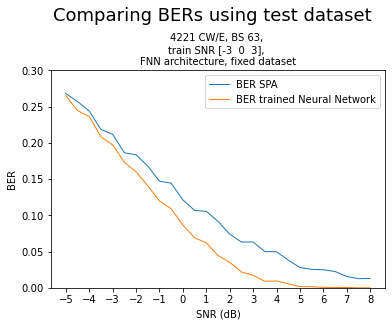

The trained network achieves a normalized validation score (NVS) of 0.49


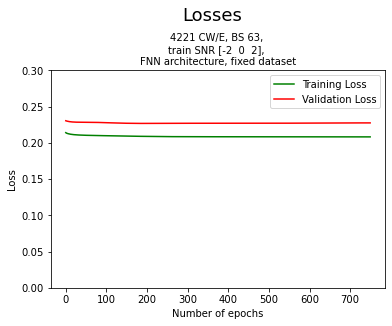

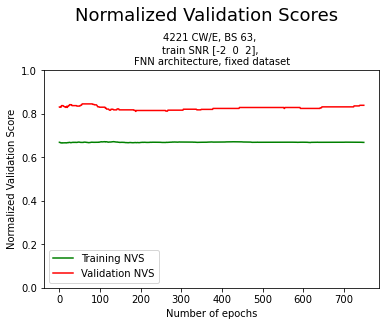

Last epoch loss train = 0.208
Last epoch loss validation = 0.228
NVS train last epoch = 0.669
NVS validation last epoch = 0.839


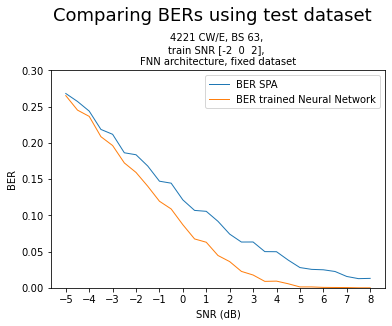

The trained network achieves a normalized validation score (NVS) of 0.489


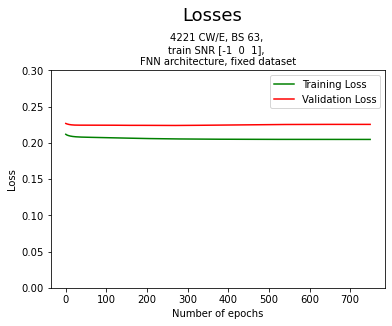

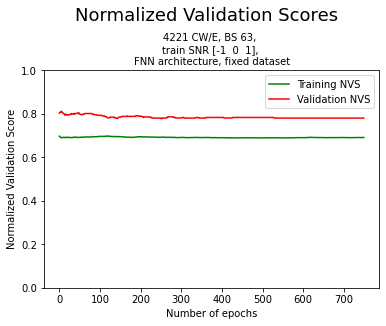

Last epoch loss train = 0.205
Last epoch loss validation = 0.225
NVS train last epoch = 0.691
NVS validation last epoch = 0.781


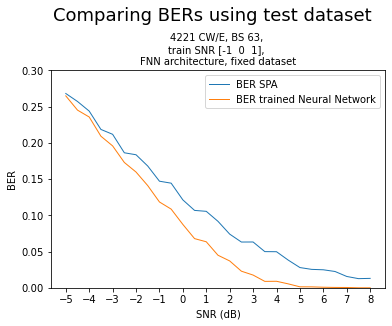

The trained network achieves a normalized validation score (NVS) of 0.491


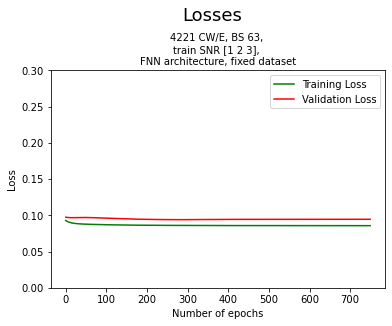

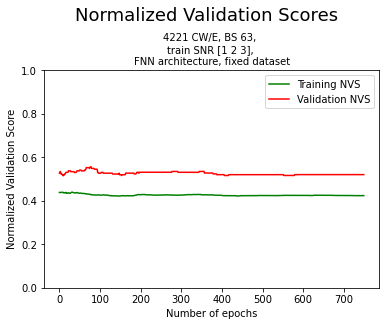

Last epoch loss train = 0.086
Last epoch loss validation = 0.095
NVS train last epoch = 0.424
NVS validation last epoch = 0.521


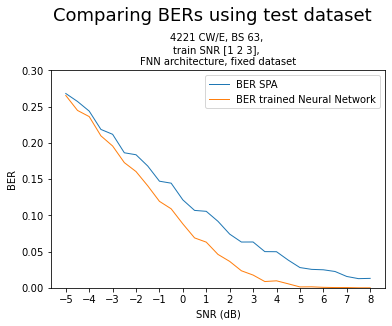

The trained network achieves a normalized validation score (NVS) of 0.492


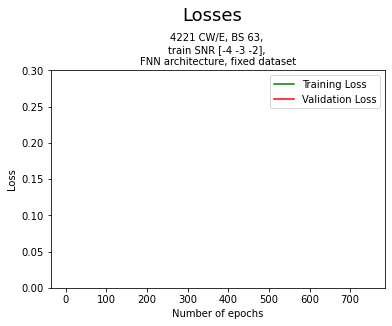

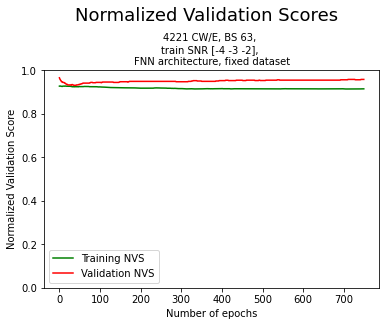

Last epoch loss train = 0.409
Last epoch loss validation = 0.429
NVS train last epoch = 0.915
NVS validation last epoch = 0.958


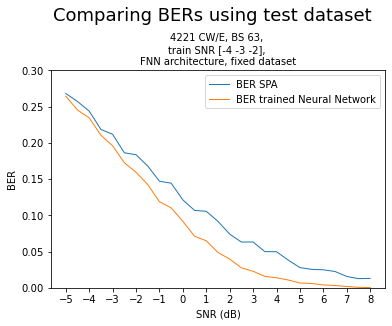

The trained network achieves a normalized validation score (NVS) of 0.546


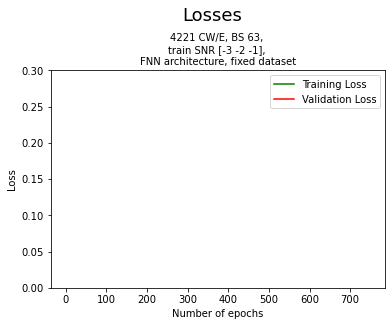

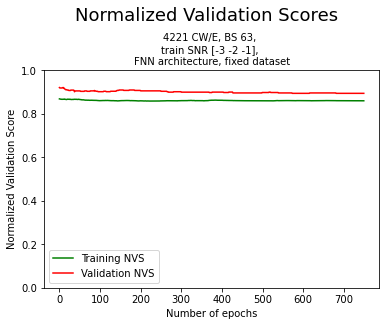

Last epoch loss train = 0.346
Last epoch loss validation = 0.367
NVS train last epoch = 0.86
NVS validation last epoch = 0.894


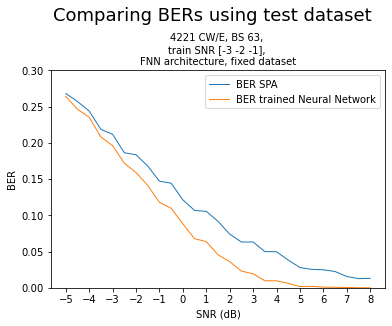

The trained network achieves a normalized validation score (NVS) of 0.496


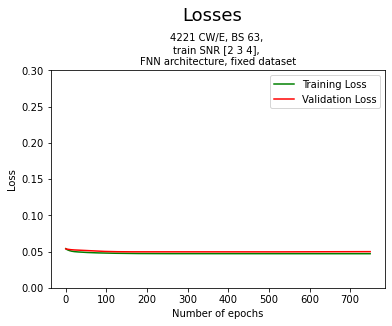

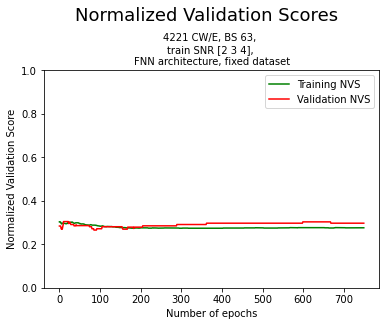

Last epoch loss train = 0.047
Last epoch loss validation = 0.05
NVS train last epoch = 0.276
NVS validation last epoch = 0.297


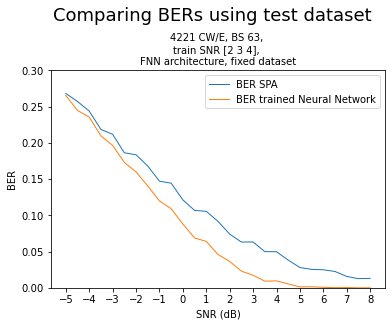

The trained network achieves a normalized validation score (NVS) of 0.492


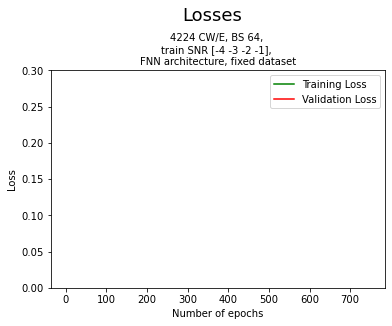

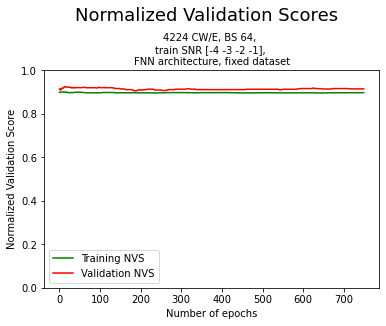

Last epoch loss train = 0.379
Last epoch loss validation = 0.389
NVS train last epoch = 0.897
NVS validation last epoch = 0.915


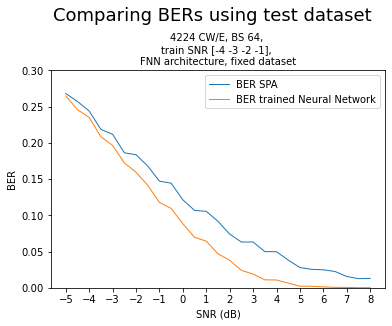

The trained network achieves a normalized validation score (NVS) of 0.503


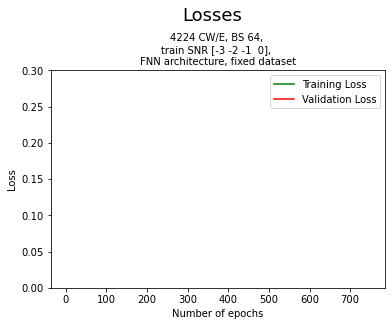

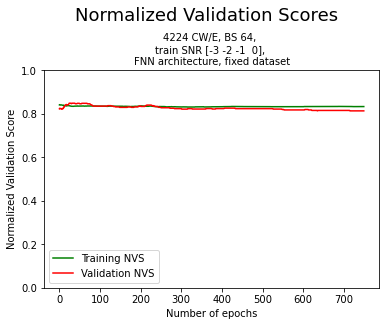

Last epoch loss train = 0.312
Last epoch loss validation = 0.321
NVS train last epoch = 0.834
NVS validation last epoch = 0.814


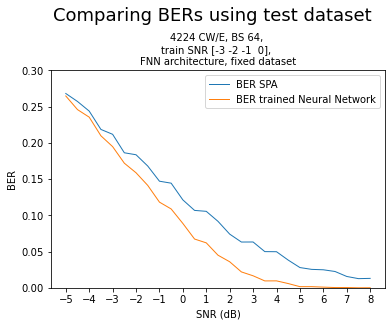

The trained network achieves a normalized validation score (NVS) of 0.491


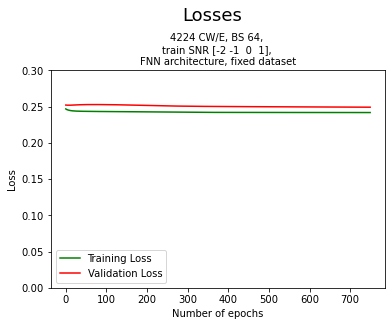

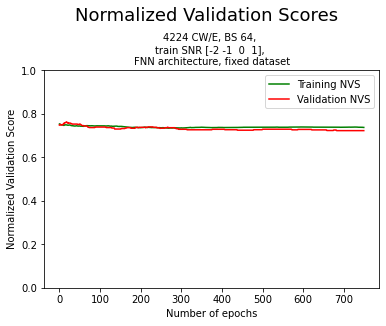

Last epoch loss train = 0.242
Last epoch loss validation = 0.249
NVS train last epoch = 0.738
NVS validation last epoch = 0.723


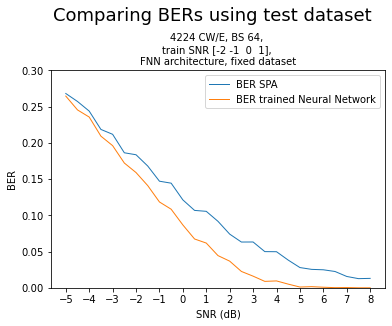

The trained network achieves a normalized validation score (NVS) of 0.488


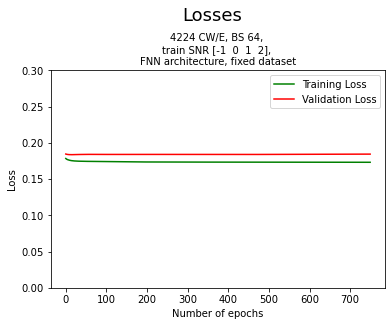

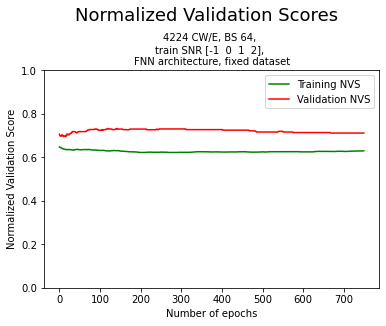

Last epoch loss train = 0.173
Last epoch loss validation = 0.184
NVS train last epoch = 0.63
NVS validation last epoch = 0.712


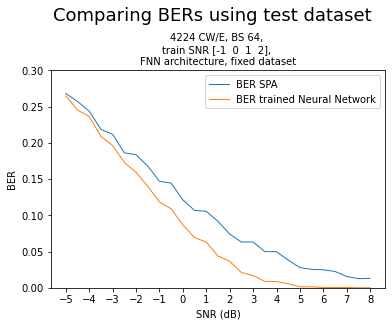

The trained network achieves a normalized validation score (NVS) of 0.488


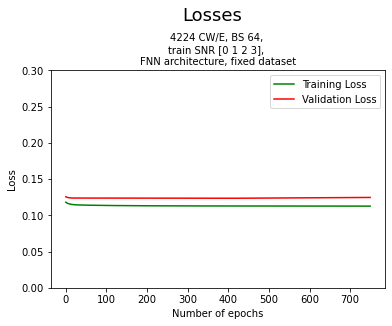

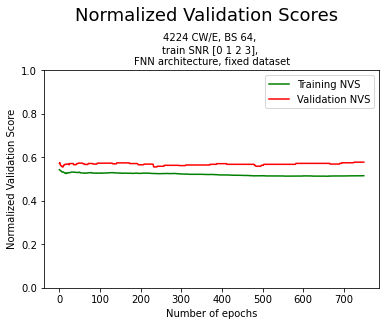

Last epoch loss train = 0.113
Last epoch loss validation = 0.125
NVS train last epoch = 0.515
NVS validation last epoch = 0.578


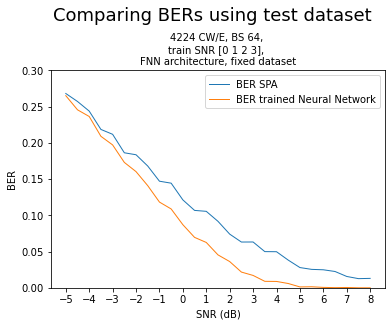

The trained network achieves a normalized validation score (NVS) of 0.49


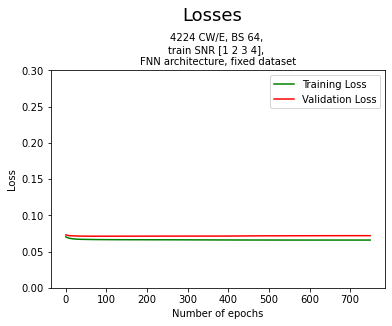

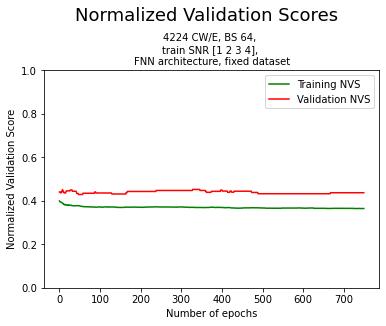

Last epoch loss train = 0.066
Last epoch loss validation = 0.072
NVS train last epoch = 0.365
NVS validation last epoch = 0.437


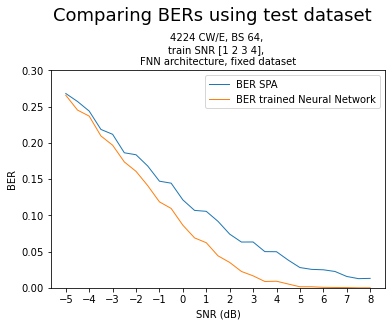

The trained network achieves a normalized validation score (NVS) of 0.489


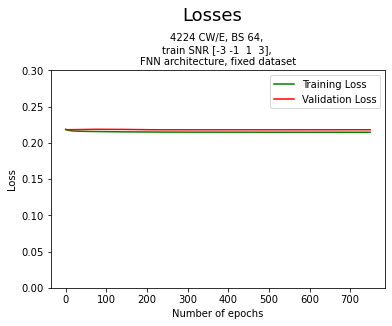

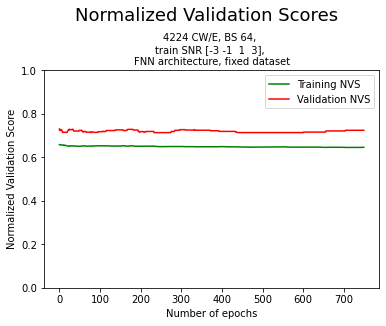

Last epoch loss train = 0.215
Last epoch loss validation = 0.218
NVS train last epoch = 0.646
NVS validation last epoch = 0.724


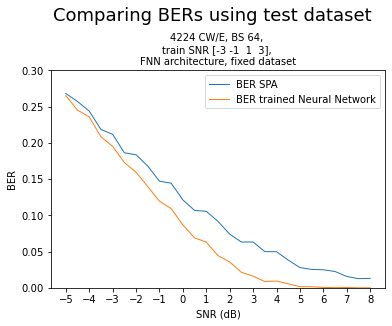

The trained network achieves a normalized validation score (NVS) of 0.488


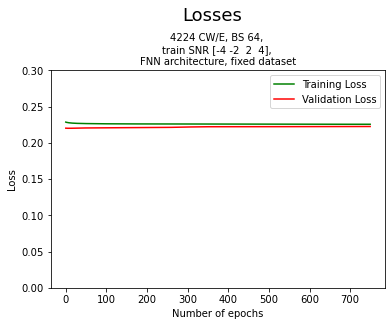

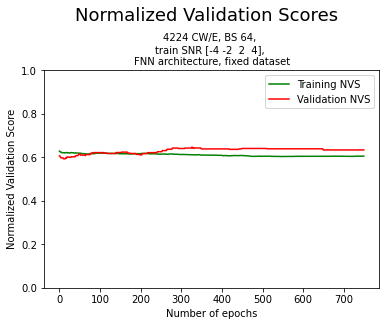

Last epoch loss train = 0.226
Last epoch loss validation = 0.223
NVS train last epoch = 0.605
NVS validation last epoch = 0.634


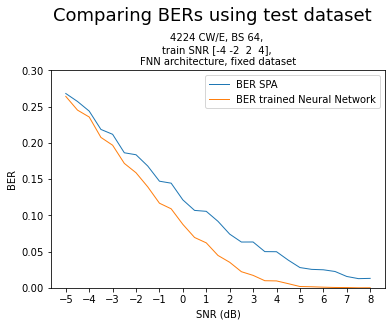

The trained network achieves a normalized validation score (NVS) of 0.49


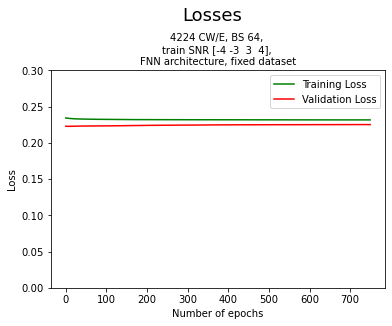

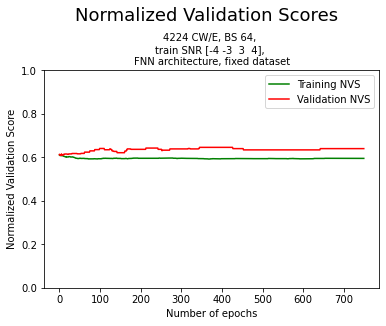

Last epoch loss train = 0.232
Last epoch loss validation = 0.225
NVS train last epoch = 0.595
NVS validation last epoch = 0.64


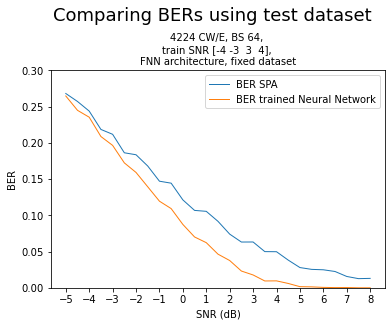

The trained network achieves a normalized validation score (NVS) of 0.493


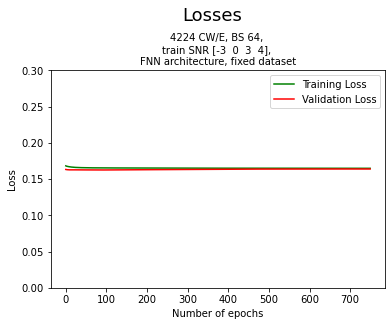

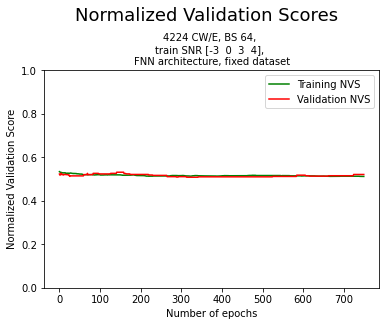

Last epoch loss train = 0.165
Last epoch loss validation = 0.164
NVS train last epoch = 0.512
NVS validation last epoch = 0.521


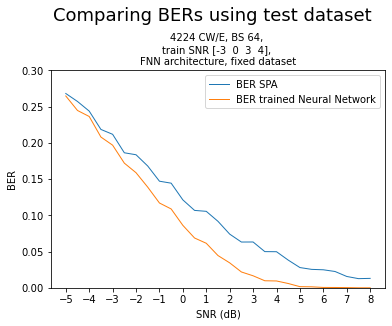

The trained network achieves a normalized validation score (NVS) of 0.487


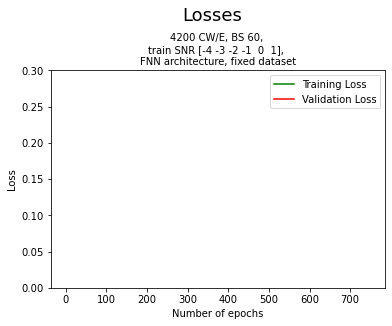

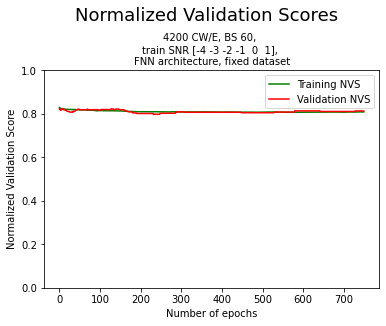

Last epoch loss train = 0.311
Last epoch loss validation = 0.326
NVS train last epoch = 0.809
NVS validation last epoch = 0.813


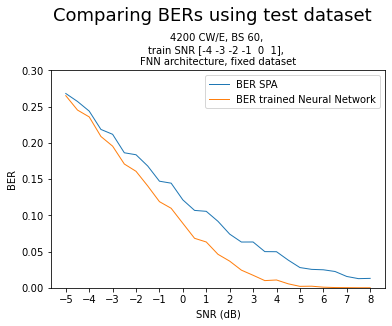

The trained network achieves a normalized validation score (NVS) of 0.497


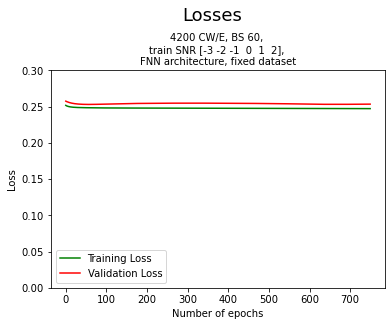

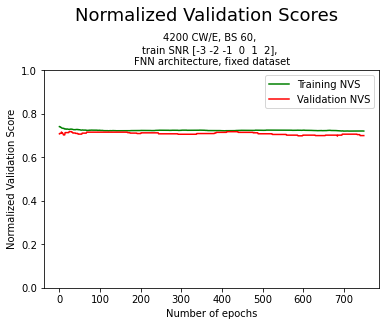

Last epoch loss train = 0.247
Last epoch loss validation = 0.253
NVS train last epoch = 0.721
NVS validation last epoch = 0.7


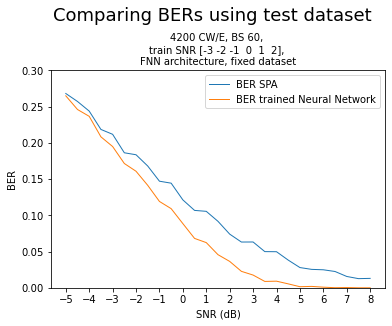

The trained network achieves a normalized validation score (NVS) of 0.492


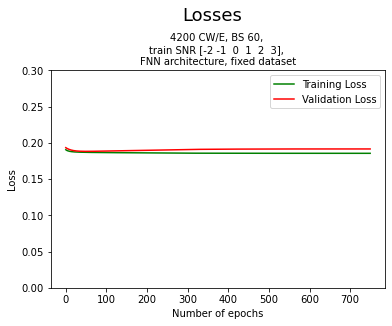

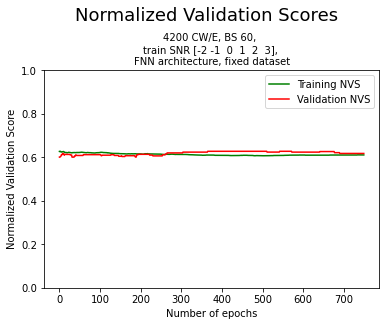

Last epoch loss train = 0.186
Last epoch loss validation = 0.192
NVS train last epoch = 0.611
NVS validation last epoch = 0.618


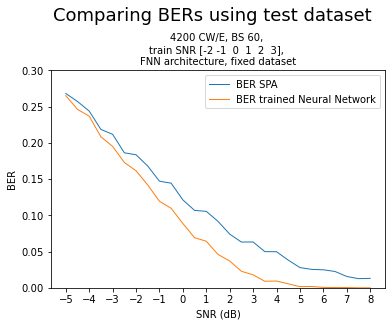

The trained network achieves a normalized validation score (NVS) of 0.495


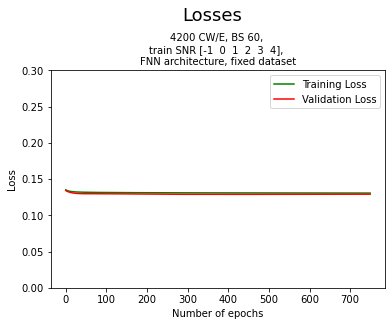

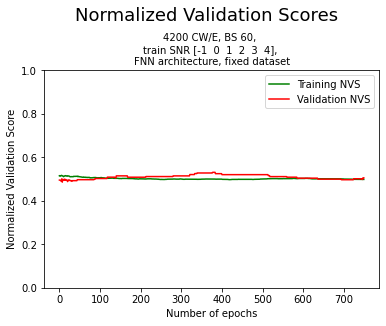

Last epoch loss train = 0.131
Last epoch loss validation = 0.129
NVS train last epoch = 0.498
NVS validation last epoch = 0.506


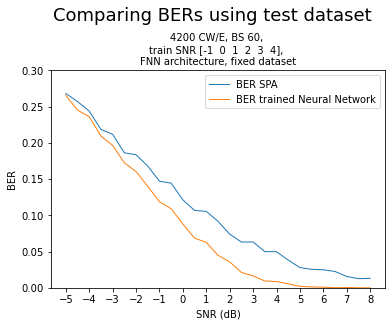

The trained network achieves a normalized validation score (NVS) of 0.489


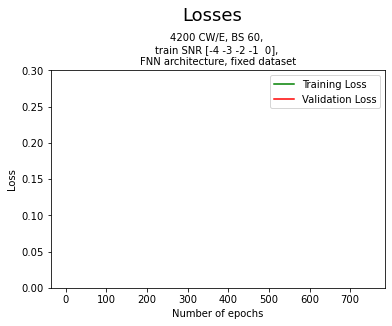

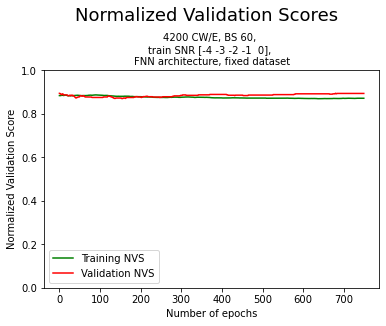

Last epoch loss train = 0.346
Last epoch loss validation = 0.357
NVS train last epoch = 0.872
NVS validation last epoch = 0.894


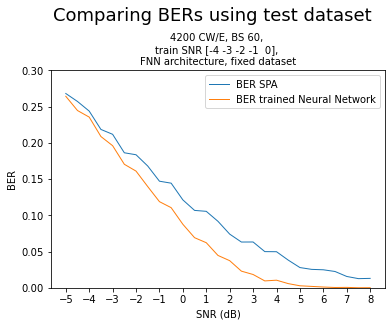

The trained network achieves a normalized validation score (NVS) of 0.497


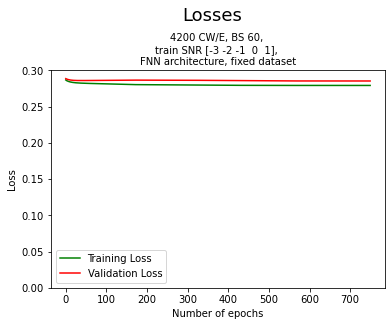

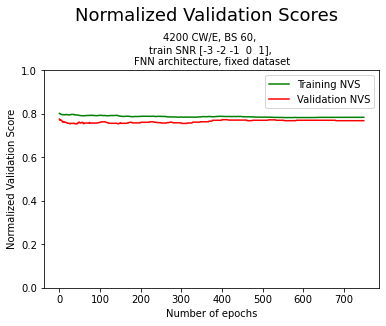

Last epoch loss train = 0.279
Last epoch loss validation = 0.285
NVS train last epoch = 0.784
NVS validation last epoch = 0.769


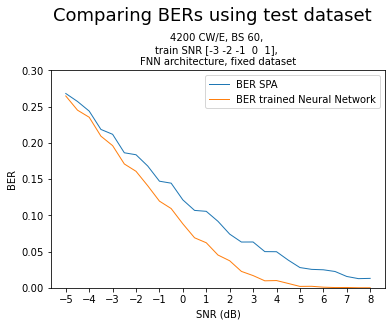

The trained network achieves a normalized validation score (NVS) of 0.495


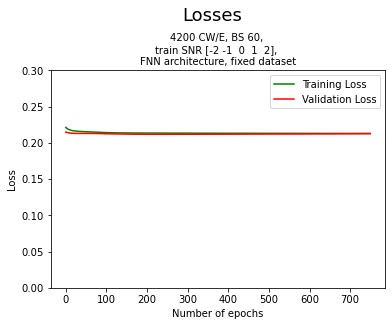

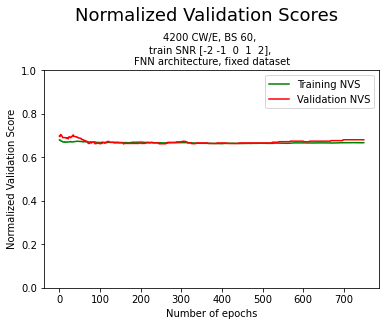

Last epoch loss train = 0.213
Last epoch loss validation = 0.213
NVS train last epoch = 0.668
NVS validation last epoch = 0.681


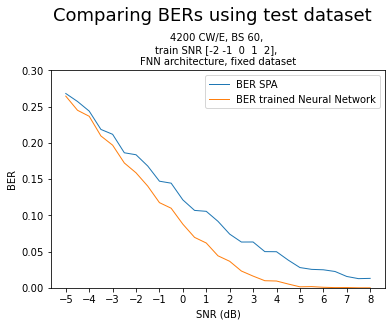

The trained network achieves a normalized validation score (NVS) of 0.49


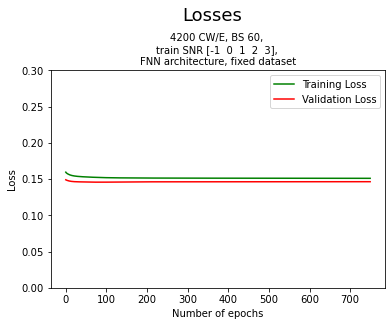

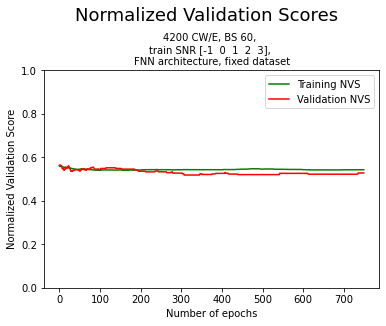

Last epoch loss train = 0.151
Last epoch loss validation = 0.146
NVS train last epoch = 0.543
NVS validation last epoch = 0.528


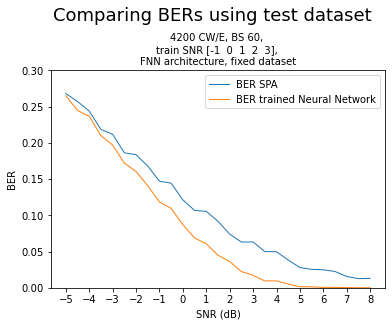

The trained network achieves a normalized validation score (NVS) of 0.491


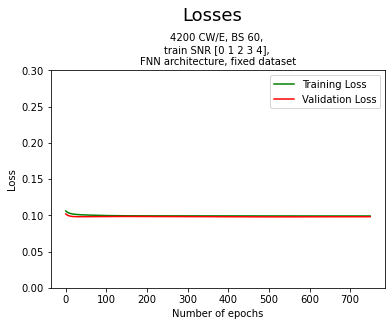

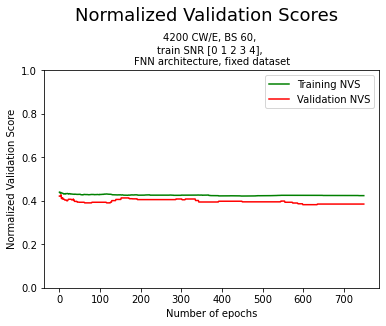

Last epoch loss train = 0.099
Last epoch loss validation = 0.098
NVS train last epoch = 0.424
NVS validation last epoch = 0.385


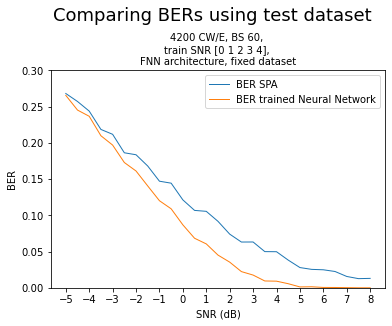

The trained network achieves a normalized validation score (NVS) of 0.49


In [28]:
paths_to_experiment_checkpoints = glob.glob(os.path.join(
    "checkpoints", 
    "*_combo*"))

for path in paths_to_experiment_checkpoints:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))

    plots.plot_from_checkpoint_losses(checkpoint)
    plots.plot_from_checkpoint_nvs(checkpoint)
    metrics.evaluate_values_for_last_epoch(checkpoint)

    # load trained neural network
    spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
    spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

    # calculate BER of trained neural network on test dataset 
    nn_BER_per_snr_test = metrics.bers_per_snr_nn(
        spa_nn=spa_nn_to_test,
        input_llr=x_test,
        target=y_test,
        codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
        batch_size=codewords_in_dataset_test)

    nvs_test = metrics.calculate_normalized_validation_score(
        bit_error_rate_nn=nn_BER_per_snr_test, 
        bit_error_rate_spa=spa_BER_per_snr_test)

    plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
    print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

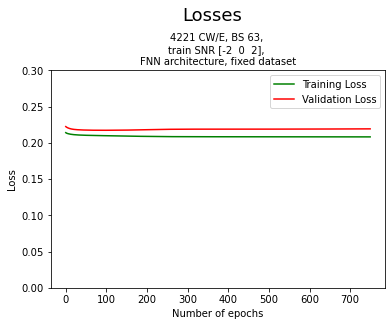

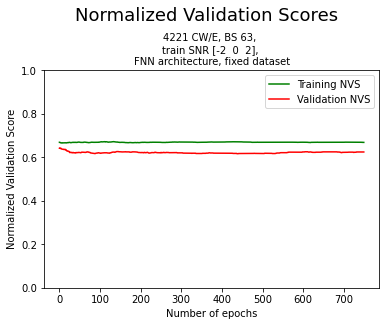

Last epoch loss train = 0.208
Last epoch loss validation = 0.219
NVS train last epoch = 0.669
NVS validation last epoch = 0.625


In [29]:
# check if NVS of validation dataset is more reliable if 500 codewords per SNR are used 
# instead of a total of 420 codewords in the validation set 

path = os.path.join("checkpoints", "2021-07-15_12-48-24ex_snr_add-combo_-2_0_2_500cw_per_SNR_in_validation_set")
checkpoint = torch.load(path, map_location=torch.device('cpu'))

plots.plot_from_checkpoint_losses(checkpoint)
plots.plot_from_checkpoint_nvs(checkpoint)
metrics.evaluate_values_for_last_epoch(checkpoint)

# Experiment On the Fly Training Set 
*Hypothesis: "An on the fly created training dataset is better for training network as the network is exposed to more and different forms of noise."*   

For plotting the training loss is normalized with the number of codewords in the training dataset, the validation loss is normalized with the number of codewords in the validation dataset.

**Fixed training parameters:**
- all-zero codeword 
- batch size 65
- fnn structure
- 2000 epochs

**Fixed validation set parameters:**
- 500 all-zero codewords 
- use SNR from training dataset
- Validation on the validation dataset is done every epoch.

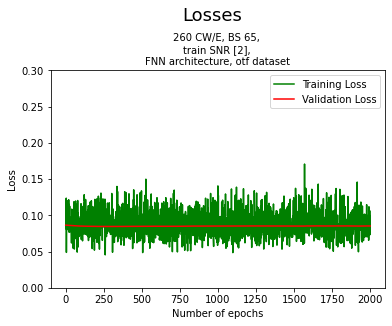

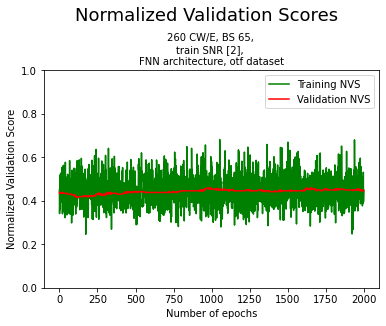

Last epoch loss train = 0.084
Last epoch loss validation = 0.085
NVS train last epoch = 0.449
NVS validation last epoch = 0.446


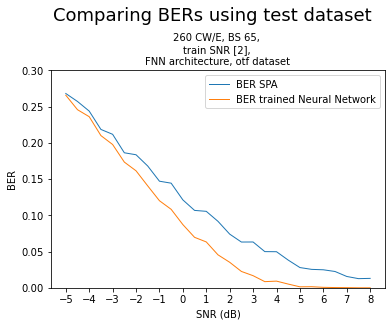

The trained network achieves a normalized validation score (NVS) of 0.49


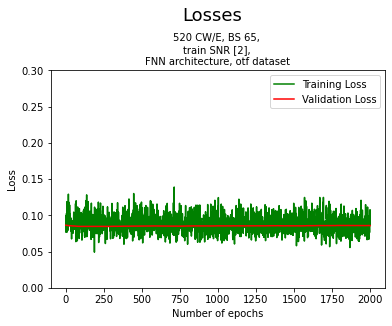

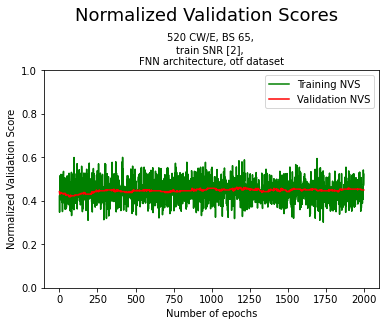

Last epoch loss train = 0.107
Last epoch loss validation = 0.086
NVS train last epoch = 0.522
NVS validation last epoch = 0.45


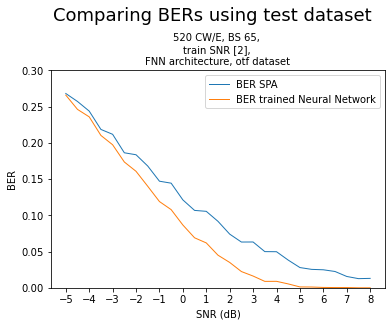

The trained network achieves a normalized validation score (NVS) of 0.488


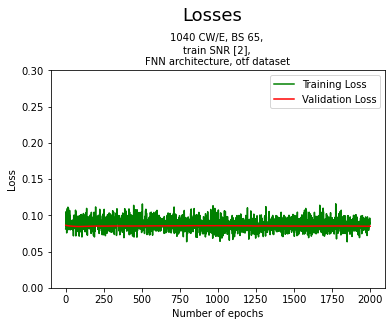

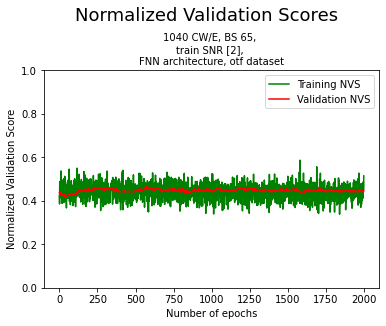

Last epoch loss train = 0.088
Last epoch loss validation = 0.085
NVS train last epoch = 0.515
NVS validation last epoch = 0.446


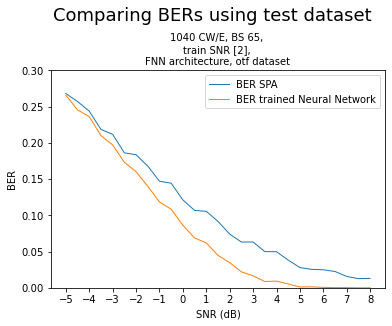

The trained network achieves a normalized validation score (NVS) of 0.487


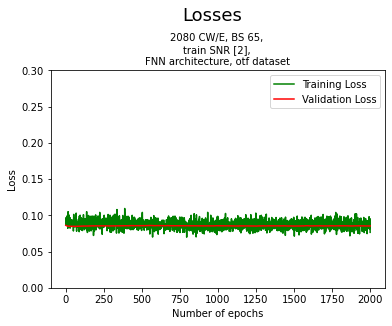

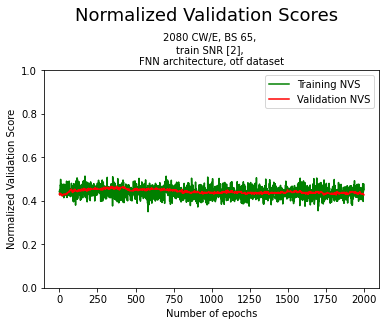

Last epoch loss train = 0.077
Last epoch loss validation = 0.085
NVS train last epoch = 0.454
NVS validation last epoch = 0.427


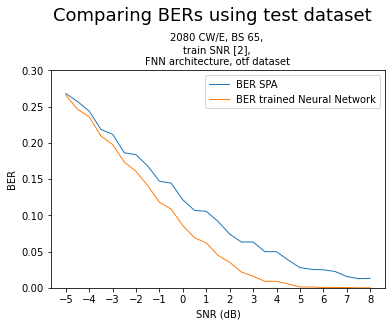

The trained network achieves a normalized validation score (NVS) of 0.487


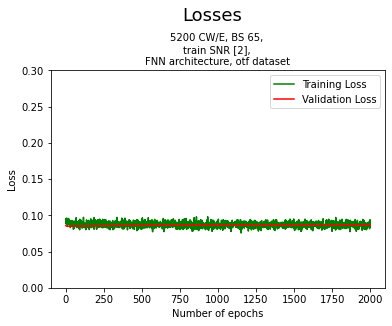

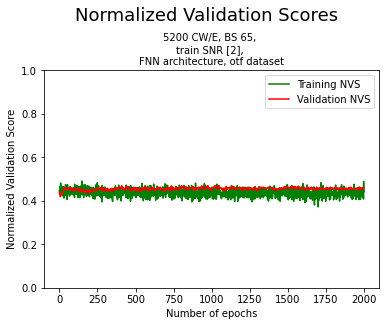

Last epoch loss train = 0.084
Last epoch loss validation = 0.086
NVS train last epoch = 0.443
NVS validation last epoch = 0.458


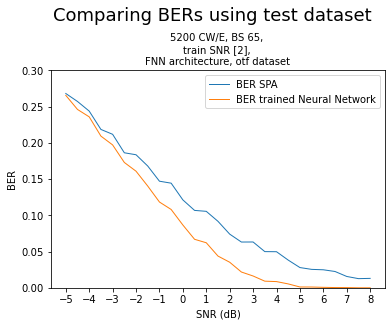

The trained network achieves a normalized validation score (NVS) of 0.486


In [30]:
paths_to_experiment_checkpoints = glob.glob(os.path.join(
    "checkpoints", 
    "*otf_*fnn"))

for path in paths_to_experiment_checkpoints:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))

    plots.plot_from_checkpoint_losses(checkpoint)
    plots.plot_from_checkpoint_nvs(checkpoint)
    metrics.evaluate_values_for_last_epoch(checkpoint)

    # load trained neural network
    spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
    spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

    # calculate BER of trained neural network on test dataset 
    nn_BER_per_snr_test = metrics.bers_per_snr_nn(
        spa_nn=spa_nn_to_test,
        input_llr=x_test,
        target=y_test,
        codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
        batch_size=codewords_in_dataset_test)

    nvs_test = metrics.calculate_normalized_validation_score(
        bit_error_rate_nn=nn_BER_per_snr_test, 
        bit_error_rate_spa=spa_BER_per_snr_test)

    plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
    print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

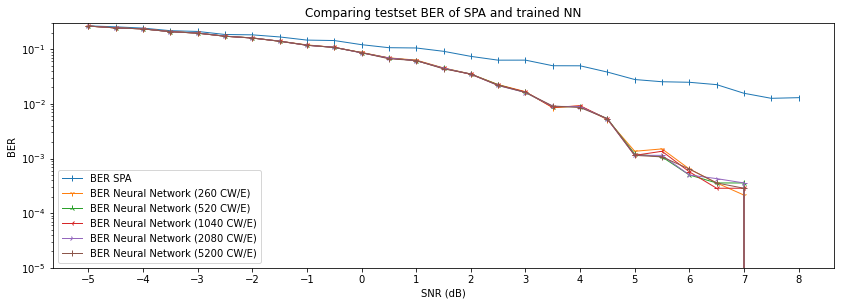

In [31]:
# executing this cell will take ~ 2.5 minutes
paths_to_experiment_checkpoints = glob.glob(os.path.join("checkpoints", "*otf_*fnn"))
results_to_plot = {}

for path in paths_to_experiment_checkpoints:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    label = f'{checkpoint["codewords_in_dataset_train"]} CW/E'
    
    # load trained neural network
    spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
    spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

    # calculate BER of trained neural network on test dataset 
    nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

    nvs_test = metrics.calculate_normalized_validation_score(
        bit_error_rate_nn=nn_BER_per_snr_test, 
        bit_error_rate_spa=spa_BER_per_snr_test)
    
    results_to_plot[label] = [nn_BER_per_snr_test, nvs_test]

plots.plot_multiple_bers_per_snr(results_to_plot, snr_range_test, spa_BER_per_snr_test=spa_BER_per_snr_test)

In [32]:
# compare how much SNR (dB) could be gained by using the neural network
nn_bers_per_snr = results_to_plot['260 CW/E'][0]
for i in range(snr_range_test.shape[0]):
    print(f"Difference in BER between NN and SPA for SNR (dB) {snr_range_test[i]}: {round(spa_BER_per_snr_test[0][i] - nn_bers_per_snr[0][i], 3)}")
    print(f"Comparing BER NN {round(nn_bers_per_snr[0][i], 3)} and BER SPA {round(spa_BER_per_snr_test[0][i], 3)}")


Difference in BER between NN and SPA for SNR (dB) -5.0: 0.002
Comparing BER NN 0.266 and BER SPA 0.268
Difference in BER between NN and SPA for SNR (dB) -4.5: 0.011
Comparing BER NN 0.246 and BER SPA 0.257
Difference in BER between NN and SPA for SNR (dB) -4.0: 0.008
Comparing BER NN 0.236 and BER SPA 0.244
Difference in BER between NN and SPA for SNR (dB) -3.5: 0.009
Comparing BER NN 0.21 and BER SPA 0.218
Difference in BER between NN and SPA for SNR (dB) -3.0: 0.014
Comparing BER NN 0.198 and BER SPA 0.212
Difference in BER between NN and SPA for SNR (dB) -2.5: 0.013
Comparing BER NN 0.173 and BER SPA 0.186
Difference in BER between NN and SPA for SNR (dB) -2.0: 0.022
Comparing BER NN 0.161 and BER SPA 0.184
Difference in BER between NN and SPA for SNR (dB) -1.5: 0.027
Comparing BER NN 0.141 and BER SPA 0.168
Difference in BER between NN and SPA for SNR (dB) -1.0: 0.027
Comparing BER NN 0.12 and BER SPA 0.147
Difference in BER between NN and SPA for SNR (dB) -0.5: 0.036
Comparing BER

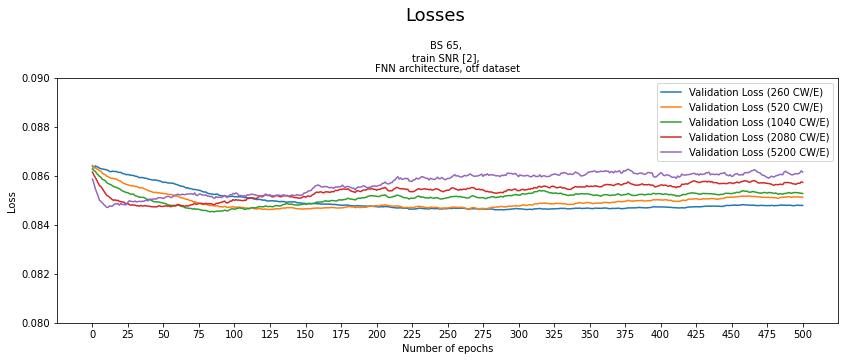

In [33]:
# plot the losses of the otf validation set during training for the first 250 epochs 
paths_to_experiment_checkpoints = glob.glob(os.path.join(
    "checkpoints", 
    "*otf_*fnn"))

last_plotted_epoch = 500

plt.figure(0, figsize=(14, 4.5))
for path in paths_to_experiment_checkpoints:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    losses_validation = checkpoint["losses_validation"]
    x_axis_losses_validation = []
    y_axis_losses_validation = []
    for key, value in losses_validation.items():
        if last_plotted_epoch and key > last_plotted_epoch:
            break
        x_axis_losses_validation.append(key)
        y_axis_losses_validation.append(value)
    normalized_y_axis_losses_validation = np.array(y_axis_losses_validation) / checkpoint["codewords_in_dataset_validation"]
    codewords_in_dataset_train = checkpoint["codewords_in_dataset_train"]
    plt.plot(x_axis_losses_validation, normalized_y_axis_losses_validation, label=f"Validation Loss ({codewords_in_dataset_train} CW/E)")
    
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.ylim((0.08, 0.09))
plt.xticks(np.arange(0, last_plotted_epoch + 1, 25))
plt.legend()
batchsize = checkpoint["batch_size_train"]
snr_range_train = checkpoint["snr_range_train"]
architecture = checkpoint["network_architecture"]
dataset_state_train = checkpoint["dataset_state_train"]
plt.suptitle("Losses", fontsize=18, y=1.1)
plt.title(f"BS {batchsize}, \ntrain SNR {snr_range_train}, \n{architecture.upper()} architecture, {dataset_state_train} dataset", fontsize=10)
#plt.savefig(os.path.join("../", "bachelor_thesis", "plots", "experiments-otf", "compare_validation_losses.pdf"), bbox_inches='tight')
plt.show()

## Different Batchsizes for On the Fly Training Set

**Fixed training parameters:**
- all-zero codeword 
- fnn structure
- 4096 CW/E
- 2000 epochs

**Fixed validation set parameters:**
- 500 all-zero codewords 
- use SNR from training dataset
- Validation on the validation dataset is done every epoch.

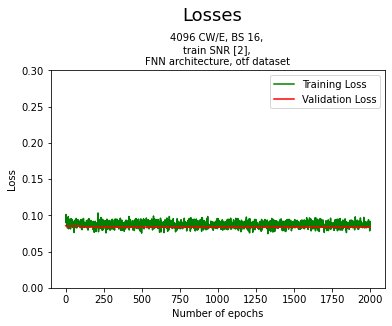

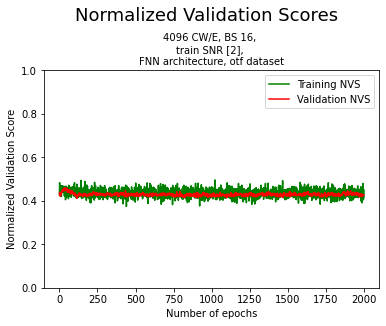

Last epoch loss train = 0.085
Last epoch loss validation = 0.083
NVS train last epoch = 0.414
NVS validation last epoch = 0.427


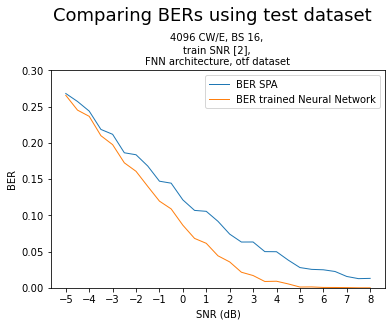

The trained network achieves a normalized validation score (NVS) of 0.487


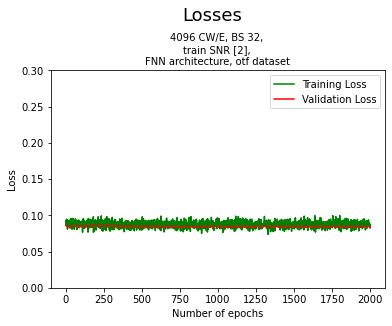

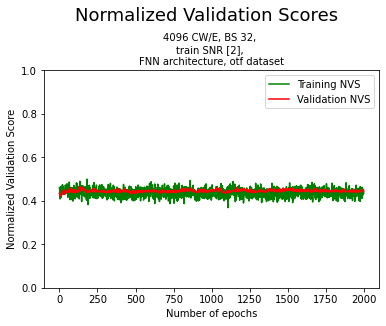

Last epoch loss train = 0.083
Last epoch loss validation = 0.085
NVS train last epoch = 0.435
NVS validation last epoch = 0.442


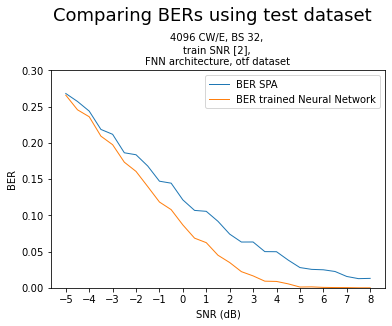

The trained network achieves a normalized validation score (NVS) of 0.487


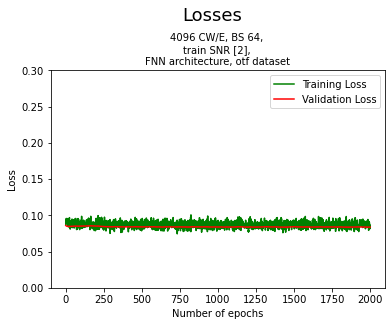

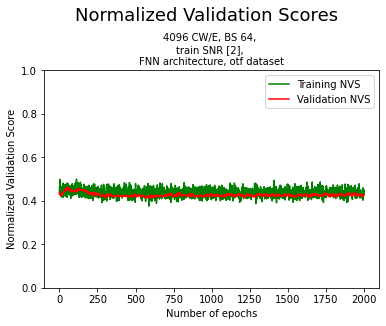

Last epoch loss train = 0.083
Last epoch loss validation = 0.084
NVS train last epoch = 0.449
NVS validation last epoch = 0.427


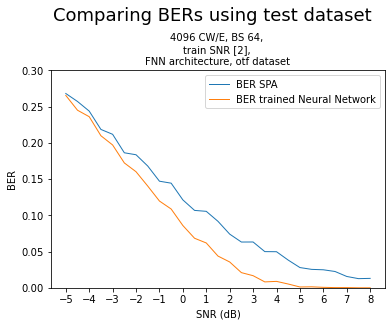

The trained network achieves a normalized validation score (NVS) of 0.486


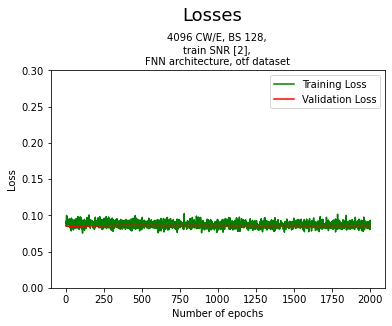

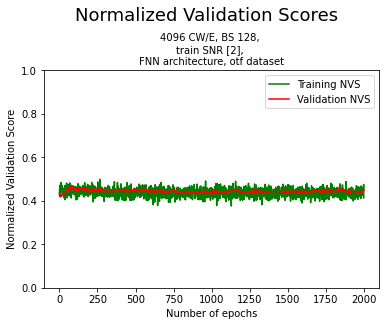

Last epoch loss train = 0.087
Last epoch loss validation = 0.086
NVS train last epoch = 0.413
NVS validation last epoch = 0.45


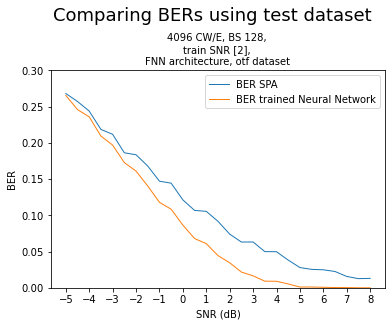

The trained network achieves a normalized validation score (NVS) of 0.486


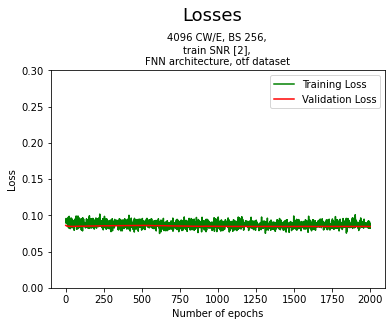

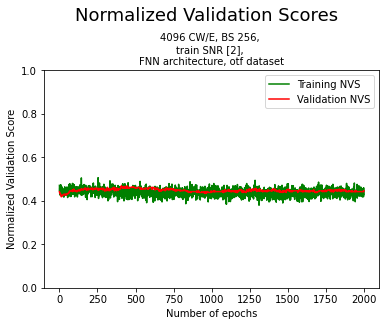

Last epoch loss train = 0.083
Last epoch loss validation = 0.085
NVS train last epoch = 0.429
NVS validation last epoch = 0.446


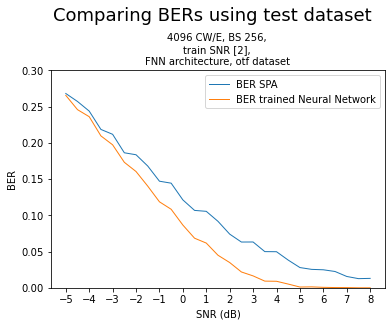

The trained network achieves a normalized validation score (NVS) of 0.487


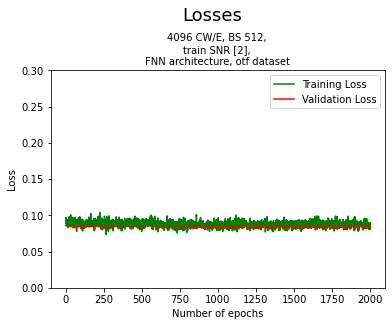

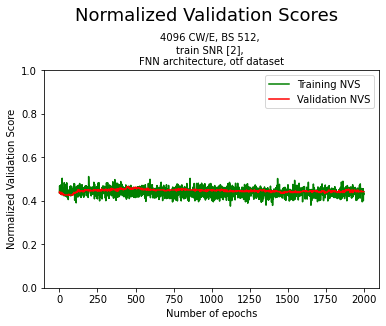

Last epoch loss train = 0.082
Last epoch loss validation = 0.085
NVS train last epoch = 0.442
NVS validation last epoch = 0.442


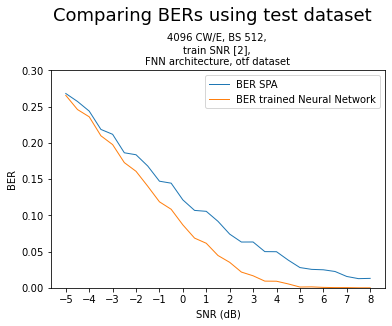

The trained network achieves a normalized validation score (NVS) of 0.487


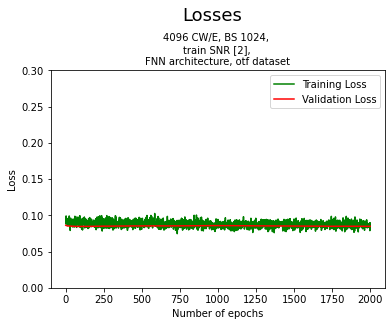

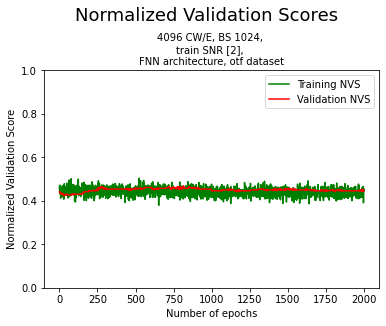

Last epoch loss train = 0.087
Last epoch loss validation = 0.085
NVS train last epoch = 0.444
NVS validation last epoch = 0.446


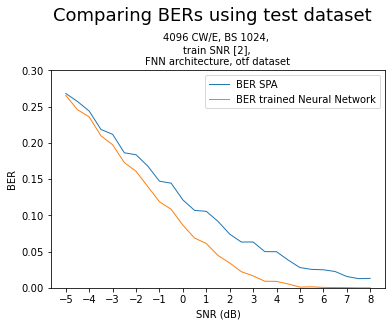

The trained network achieves a normalized validation score (NVS) of 0.487


In [34]:
paths_to_experiment_checkpoints = glob.glob(os.path.join(
    "checkpoints", 
    "*otf-bs_*fnn"))

for path in paths_to_experiment_checkpoints:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))

    plots.plot_from_checkpoint_losses(checkpoint)
    plots.plot_from_checkpoint_nvs(checkpoint)
    metrics.evaluate_values_for_last_epoch(checkpoint)

    # load trained neural network
    spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
    spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

    # calculate BER of trained neural network on test dataset 
    nn_BER_per_snr_test = metrics.bers_per_snr_nn(
        spa_nn=spa_nn_to_test,
        input_llr=x_test,
        target=y_test,
        codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
        batch_size=codewords_in_dataset_test)

    nvs_test = metrics.calculate_normalized_validation_score(
        bit_error_rate_nn=nn_BER_per_snr_test, 
        bit_error_rate_spa=spa_BER_per_snr_test)

    plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
    print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

calculating checkpoints\2021-06-29_16-25-24_ex_otf-bs_4096cw_bs16_fnn
calculating checkpoints\2021-06-29_16-25-27_ex_otf-bs_4096cw_bs32_fnn
calculating checkpoints\2021-06-29_16-25-30_ex_otf-bs_4096cw_bs64_fnn
calculating checkpoints\2021-06-29_16-25-34_ex_otf-bs_4096cw_bs128_fnn
calculating checkpoints\2021-06-29_16-26-14_ex_otf-bs_4096cw_bs256_fnn
calculating checkpoints\2021-06-29_16-26-38_ex_otf-bs_4096cw_bs512_fnn
calculating checkpoints\2021-06-29_16-27-13_ex_otf-bs_4096cw_bs1024_fnn


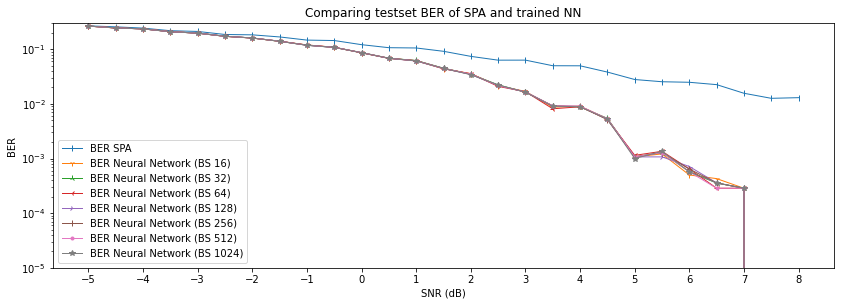

In [13]:
# executing this cell will take ~ 5 minutes
paths_to_experiment_checkpoints = paths_to_experiment_checkpoints = glob.glob(os.path.join("checkpoints", "*otf-bs_*fnn"))
results_to_plot = {}

for path in paths_to_experiment_checkpoints:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    label = f'BS {checkpoint["batch_size_train"]}'
    
    # load trained neural network
    spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
    spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

    # calculate BER of trained neural network on test dataset 
    nn_BER_per_snr_test = metrics.bers_per_snr_nn(
    spa_nn=spa_nn_to_test,
    input_llr=x_test,
    target=y_test,
    codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
    batch_size=codewords_in_dataset_test)

    nvs_test = metrics.calculate_normalized_validation_score(
        bit_error_rate_nn=nn_BER_per_snr_test, 
        bit_error_rate_spa=spa_BER_per_snr_test)
    
    results_to_plot[label] = [nn_BER_per_snr_test, nvs_test]

plots.plot_multiple_bers_per_snr(results_to_plot, snr_range_test, spa_BER_per_snr_test=spa_BER_per_snr_test)

# Experiment Feed Forward vs. Recurrent Neural Network
*Hypothesis:  "Training with a feed forward architecture leads to a better result than a recurrent neural network structure."*   

For plotting the training loss is normalized with the number of codewords in the training dataset, the validation loss is normalized with the number of codewords in the validation dataset.

**Fixed training parameters:**
- all-zero codeword 
- batch size 64
- SNR [2]
- 750 epochs

**Fixed validation set parameters:**
- 500 all-zero codewords 
- use SNR from training dataset
- Validation on the validation dataset is done every epoch.



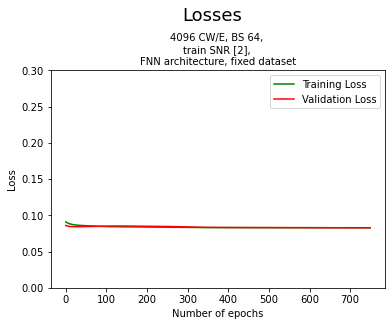

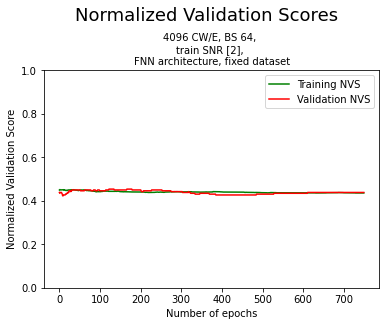

Last epoch loss train = 0.083
Last epoch loss validation = 0.083
NVS train last epoch = 0.436
NVS validation last epoch = 0.438


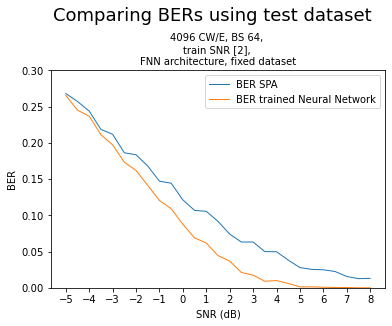

The trained network achieves a normalized validation score (NVS) of 0.492


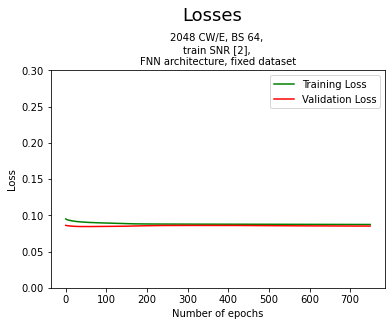

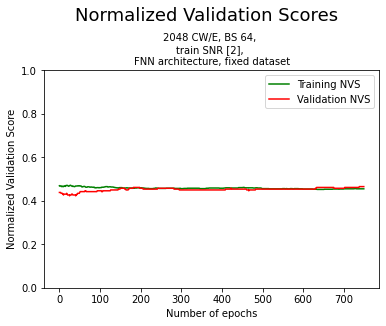

Last epoch loss train = 0.087
Last epoch loss validation = 0.085
NVS train last epoch = 0.455
NVS validation last epoch = 0.465


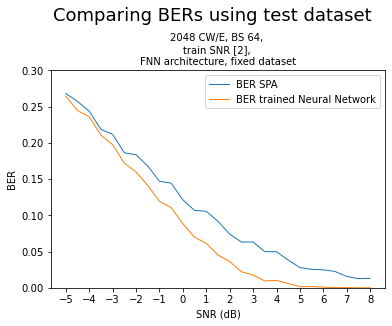

The trained network achieves a normalized validation score (NVS) of 0.494


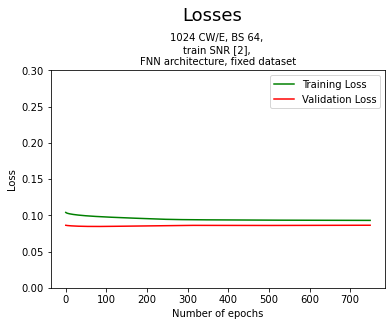

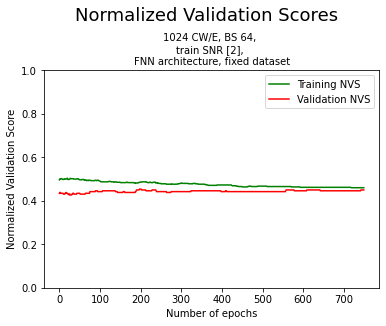

Last epoch loss train = 0.093
Last epoch loss validation = 0.086
NVS train last epoch = 0.46
NVS validation last epoch = 0.45


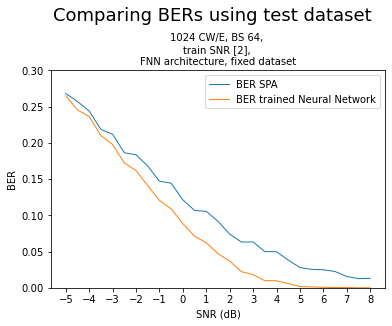

The trained network achieves a normalized validation score (NVS) of 0.496


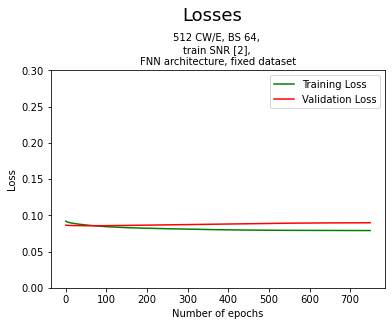

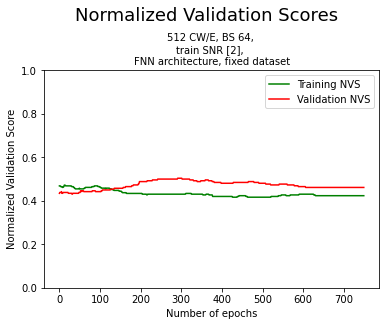

Last epoch loss train = 0.079
Last epoch loss validation = 0.09
NVS train last epoch = 0.424
NVS validation last epoch = 0.462


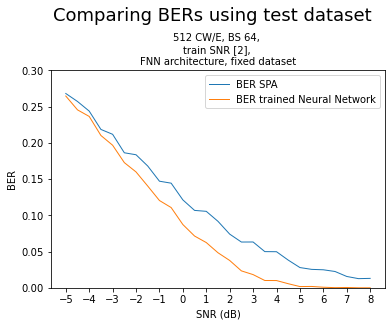

The trained network achieves a normalized validation score (NVS) of 0.498


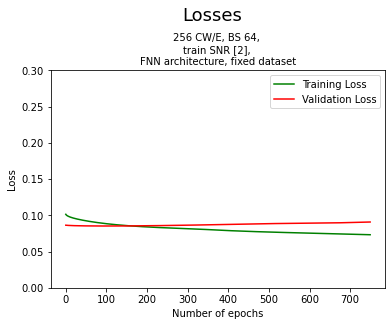

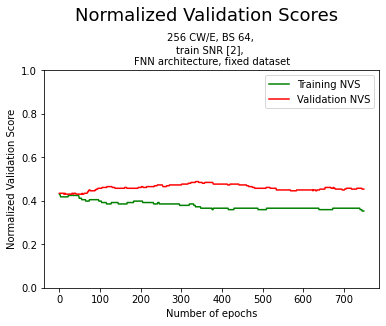

Last epoch loss train = 0.073
Last epoch loss validation = 0.091
NVS train last epoch = 0.353
NVS validation last epoch = 0.454


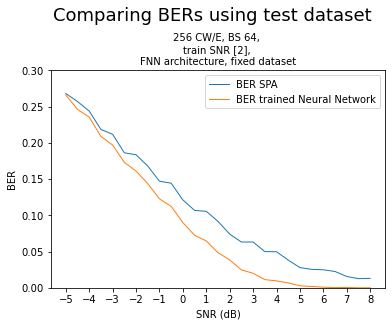

The trained network achieves a normalized validation score (NVS) of 0.508


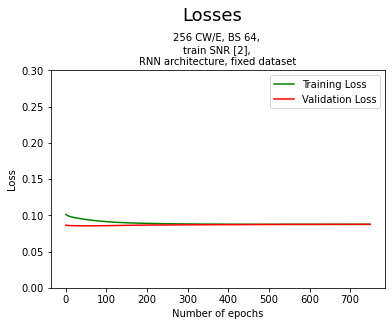

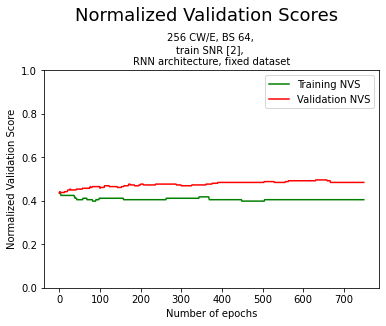

Last epoch loss train = 0.088
Last epoch loss validation = 0.088
NVS train last epoch = 0.405
NVS validation last epoch = 0.485


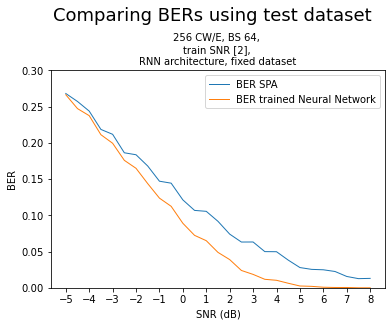

The trained network achieves a normalized validation score (NVS) of 0.51


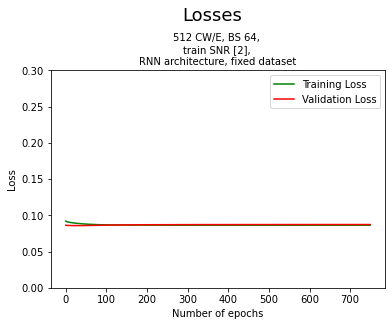

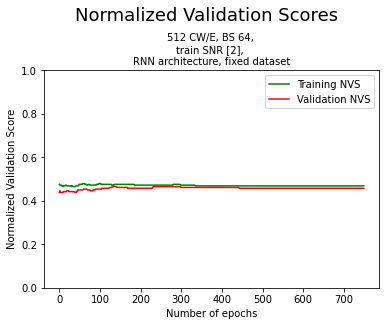

Last epoch loss train = 0.086
Last epoch loss validation = 0.087
NVS train last epoch = 0.469
NVS validation last epoch = 0.458


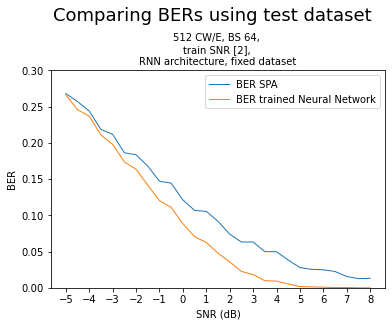

The trained network achieves a normalized validation score (NVS) of 0.497


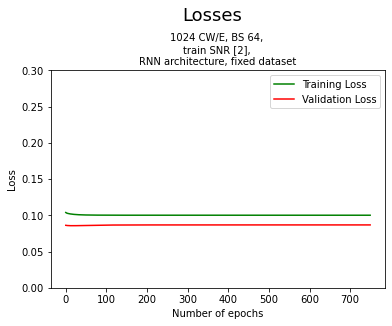

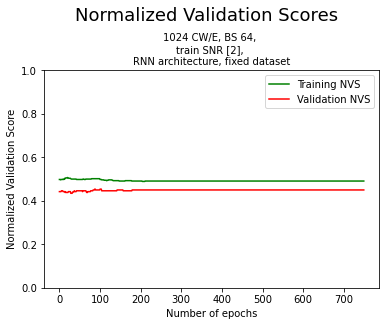

Last epoch loss train = 0.1
Last epoch loss validation = 0.087
NVS train last epoch = 0.491
NVS validation last epoch = 0.45


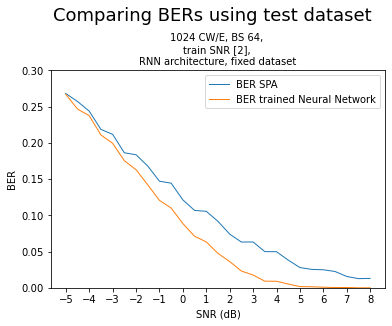

The trained network achieves a normalized validation score (NVS) of 0.498


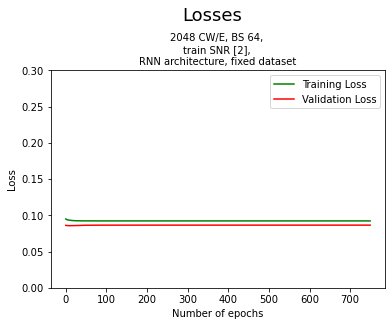

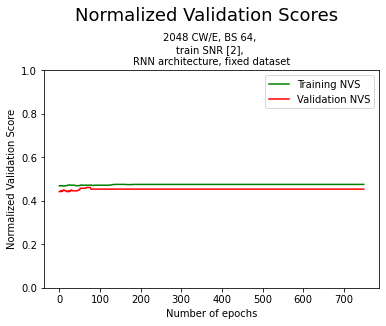

Last epoch loss train = 0.092
Last epoch loss validation = 0.086
NVS train last epoch = 0.476
NVS validation last epoch = 0.454


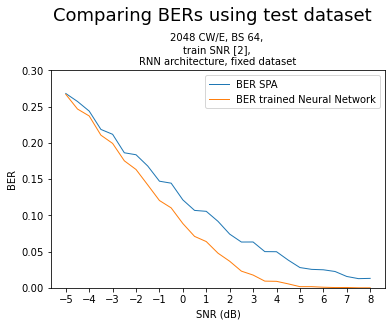

The trained network achieves a normalized validation score (NVS) of 0.498


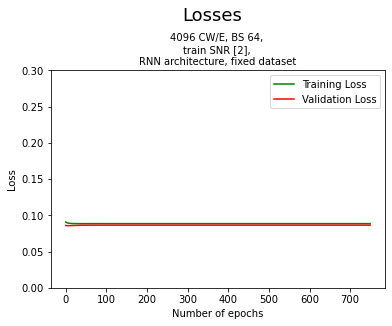

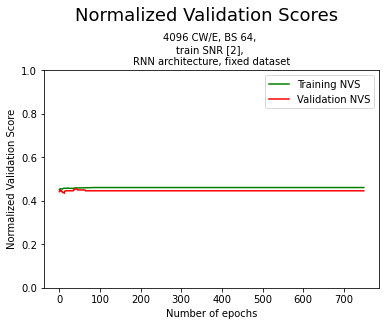

Last epoch loss train = 0.089
Last epoch loss validation = 0.086
NVS train last epoch = 0.461
NVS validation last epoch = 0.446


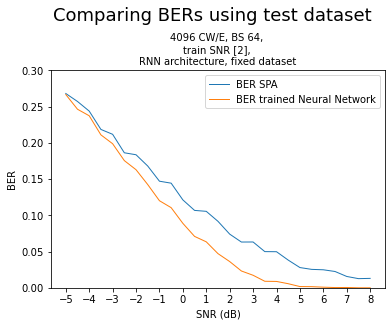

The trained network achieves a normalized validation score (NVS) of 0.498


In [6]:
paths_to_experiment_checkpoints = glob.glob(os.path.join(
    "checkpoints", 
    "*_ex_fnn_vs_rnn*"))

for path in paths_to_experiment_checkpoints:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))

    plots.plot_from_checkpoint_losses(checkpoint)
    plots.plot_from_checkpoint_nvs(checkpoint)
    metrics.evaluate_values_for_last_epoch(checkpoint)

    # load trained neural network
    spa_nn_to_test = pytorch_spa_nn.SpaNn(network_architecture=checkpoint["network_architecture"])
    spa_nn_to_test.load_state_dict(checkpoint["model_state_dict"])

    # calculate BER of trained neural network on test dataset 
    nn_BER_per_snr_test = metrics.bers_per_snr_nn(
        spa_nn=spa_nn_to_test,
        input_llr=x_test,
        target=y_test,
        codewords_per_snr_in_batch=dataset_test.codewords_per_snr_in_batch,
        batch_size=codewords_in_dataset_test)

    nvs_test = metrics.calculate_normalized_validation_score(
        bit_error_rate_nn=nn_BER_per_snr_test, 
        bit_error_rate_spa=spa_BER_per_snr_test)

    plots.plot_compare_spa_ber_and_nn_ber_test(checkpoint, spa_BER_per_snr_test, nn_BER_per_snr_test, snr_range_test)
    print(f"The trained network achieves a normalized validation score (NVS) of {round(nvs_test, 3)}")

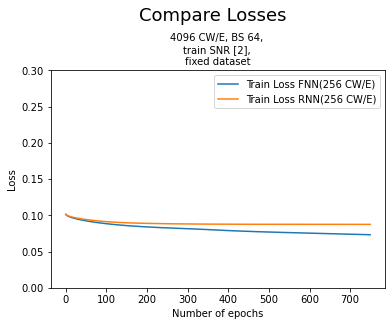

In [7]:
# plot the losses of rnn vs fnn training dataset to check for convergance 
paths_to_experiment_checkpoints = glob.glob(os.path.join(
    "checkpoints", 
    "*_ex_fnn_vs_rnn*"))

last_plotted_epoch = 749
cw_per_epoch_to_compare = 256

for path in paths_to_experiment_checkpoints:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))

    losses_train = checkpoint["losses_train"]
    codewords_in_dataset_train = checkpoint["codewords_in_dataset_train"]
    normalized_y_axis_losses_train = [loss / codewords_in_dataset_train for loss in losses_train]
    normalized_y_axis_losses_train = normalized_y_axis_losses_train[:last_plotted_epoch+1]
    
    x_axis = [i for i in range(last_plotted_epoch + 1)]
    architecture = checkpoint["network_architecture"]
    if cw_per_epoch_to_compare == codewords_in_dataset_train:
        plt.plot(x_axis, normalized_y_axis_losses_train, label=f"Train Loss {architecture.upper()}({codewords_in_dataset_train} CW/E)")
    
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.ylim((0, 0.3))
plt.legend()
batchsize = checkpoint["batch_size_train"]
snr_range_train = checkpoint["snr_range_train"]
dataset_state_train = checkpoint["dataset_state_train"]
plt.suptitle("Compare Losses", fontsize=18, y=1.1)
plt.title(f"{codewords_in_dataset_train} CW/E, BS {batchsize}, \ntrain SNR {snr_range_train}, \n{dataset_state_train} dataset", fontsize=10)
#plt.savefig(os.path.join("../", "bachelor_thesis", "plots", "experiments-fnn-vs-rnn", "compare_fnn_and_rnn_losses.pdf"), bbox_inches='tight')
plt.show()

In [8]:
# check for converging losses, compare losses of RNN and FNN 
paths_to_experiment_checkpoints = glob.glob(os.path.join("checkpoints", "*_ex_fnn_vs_rnn*"))

checkpoint = torch.load(paths_to_experiment_checkpoints[5], map_location=torch.device('cpu'))
codewords_in_dataset_train = checkpoint["codewords_in_dataset_train"]
losses_train = checkpoint["losses_train"]
normalized_y_axis_losses_train_rnn = [round(float(loss / codewords_in_dataset_train), 4) for loss in losses_train]
print("Last 15 losses RNN", normalized_y_axis_losses_train_rnn[-15:])

checkpoint = torch.load(paths_to_experiment_checkpoints[4], map_location=torch.device('cpu'))
codewords_in_dataset_train = checkpoint["codewords_in_dataset_train"]
losses_train = checkpoint["losses_train"]
normalized_y_axis_losses_train_fnn = [round(float(loss / codewords_in_dataset_train), 4) for loss in losses_train]
print("Last 15 losses FNN", normalized_y_axis_losses_train_fnn[-15:])

Last 15 losses RNN [0.0875, 0.0875, 0.0875, 0.0875, 0.0875, 0.0875, 0.0875, 0.0875, 0.0875, 0.0875, 0.0875, 0.0875, 0.0875, 0.0875, 0.0875]
Last 15 losses FNN [0.0734, 0.0734, 0.0734, 0.0733, 0.0733, 0.0733, 0.0733, 0.0733, 0.0733, 0.0733, 0.0733, 0.0733, 0.0732, 0.0732, 0.0732]


In [9]:
# take a look at trained weights in RNN
checkpoint = torch.load(paths_to_experiment_checkpoints[5], map_location=torch.device('cpu'))
print(checkpoint["model_state_dict"]["weights_odd2"].numpy())

[[0.    0.    0.    0.    0.513 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.982 0.    0.    0.968 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.882 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.778 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.521 0.    0.    0.   ]
 [0.    0.193 0.    0.    0.    0.    0.    0.    0.    0.29  0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.597 0.    0.    0.    0.    0.    0.   ]
 [0.    0.44  0.    0.    0.    0.    0.36  0.    0.    0.    0.    0.   ]
 [0.    0.    0.718 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]


In [10]:
# take a look at trained weights in FNN
checkpoint = torch.load(paths_to_experiment_checkpoints[4], map_location=torch.device('cpu'))
print(checkpoint["model_state_dict"]["weights_odd2"].numpy(),"\n")
print(checkpoint["model_state_dict"]["weights_odd3"].numpy(),"\n")
print(checkpoint["model_state_dict"]["weights_odd4"].numpy(),"\n")
print(checkpoint["model_state_dict"]["weights_odd5"].numpy(),"\n")

[[ 0.     0.     0.     0.     1.131  0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     1.964  0.     0.     0.654
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   1.082  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 2.302  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.851  0.
   0.     0.   ]
 [ 0.     0.753  0.     0.     0.     0.     0.     0.     0.    -0.109
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     2.004  0.     0.     0.     0.
   0.     0.   ]
 [ 0.     1.42   0.     0.     0.     0.     0.693  0.     0.     0.
   0.     0.   ]
 [ 0.     0.     1.024  0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0. 

In [11]:
# take a look at trained weights in FNN
path_to_checkpoint = os.path.join(
    "checkpoints", 
    "01_ex_5_5200cw_bs26_non_all_zero_codewords_in_training-same-train-and-val-snr-500valwords")

checkpoint = torch.load(path_to_checkpoint, map_location=torch.device('cpu'))
print(checkpoint["model_state_dict"]["weights_odd2"].numpy(),"\n")
print(checkpoint["model_state_dict"]["weights_odd3"].numpy(),"\n")
print(checkpoint["model_state_dict"]["weights_odd4"].numpy(),"\n")
print(checkpoint["model_state_dict"]["weights_odd5"].numpy(),"\n")

[[ 0.     0.     0.     0.     0.201  0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     3.249  0.     0.     4.812
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  -0.078  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.49   0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.532  0.
   0.     0.   ]
 [ 0.     4.166  0.     0.     0.     0.     0.     0.     0.    -6.652
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     1.425  0.     0.     0.     0.
   0.     0.   ]
 [ 0.     1.635  0.     0.     0.     0.    -1.242  0.     0.     0.
   0.     0.   ]
 [ 0.     0.     1.298  0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0. 